In [53]:
#Section 0: Initialization and Data setup

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Loading the dataset
test_data = pd.read_csv('TargetData.csv')


#Print the first 5 rows of the dataframe.
test_data.head()

'''
failure = pd.read_csv('TargetData.csv')
target = ['multilabels', 'SB', 'ROW', 'COL']
y = [None] * len(target)

y[0] = failure[['SB', 'ROW', 'COL']].values
n_classes = y[0].shape[1]

for (i, j) in zip(range(1, len(target)), ['SB', 'ROW', 'COL']):
    y[i] = failure[j].values

    print(y[i])
raise
'''
#X consists of 58 features. Each feature represents 1 test in the long test flow.
X = test_data.drop([ 'gallop 1', 'gallop 5', 'Row Shift 7',"ID","SB","COL","Margin","Block","ROW"],axis = 1)
#Y can be one of ROW,COL,SB. ROW means the failure is on a row of memory array. 
#COL means the failure is on a column of the cell array.
#SB is single bit failure inside the memory.
#Pre-pruning involves removal of columns with no toggle in value such as in 'gallop 1', 'gallop 5', 'Row Shift 7'.
#Pre-pruning also remove columns with all unique value at all entries such as "ID"

#Forming multilabel [SB,COL,ROW]
#['Overkill','SB','COL','SB+COL','ROW','ROW+SB','ROW+COL','SB+ROW+COL']
y=test_data[["SB","COL","ROW"]].as_matrix()
#y = test_data.SB+2*test_data.COL+4*test_data.ROW #alternative as a class of 8 values from 0 to 7.

#y = test_data.ROW #COL #SB #if debugging, use single label


#importing train_test_split
#perfrom train and test data split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=2, stratify=y)

#scalar transformation is done on all models for easy comparison later.
scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)    
X_test = scaler.transform(X_test)  
X_test1=X_test
X_test2=X_test

X_train_b,X_test_b,y_train_b,y_test_b=X_train,X_test,y_train,y_test

In [55]:
#Section 1: Building Random Forest based on Single Decision Tree


In [56]:
#Section 1.1 Single class decision tree 

In [57]:
#Section 1.1.1 Post pruning function on decision tree
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

#to be called later for single decision tree pruning.
def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

In [58]:
#Section 1.1.2 Building Single Decision Tree
#This is aimed to build a single decision tree with suitable depth and then fine tuned with suitable parameters
#In this case, multi-label decision tree is built
#In this scenario, to avoid exhaustive grid search, best depth is first to be identified before fine tuning min_impurity_decrease and min_weight_fraction_leaf

from sklearn.tree import DecisionTreeClassifier

max_accuracy=0
best_depth=12
best_impurity_decrease=0.0001
best_weight_fraction_leaf=0.001
non_improve_count=0

#Section 1.1.2.1 Find best depth in range of 20-40. This is because The total feature is 58, so suitable range should be in 20-40.
for DEPTH in range(20,40,1):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=DEPTH,random_state=0,min_impurity_decrease=0.0001,min_weight_fraction_leaf=0.001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(DEPTH,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_depth=DEPTH
        #prints for tuning the DEPTH - Best DEPTH = 29
        print("DEPTH = ", DEPTH)
    else:
        non_improve_count+=1
        
    if non_improve_count==4: break

#Section 1.1.2.2 Select best impurity decrease. Range in between 0.00005 to 0.0002. Based on the best Depth found earlier.   
non_improve_count=0
for impurity_decrease in range(5,20,1):

    dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=impurity_decrease*0.00001,min_weight_fraction_leaf=0.001)
    dt.fit(X_train, y_train)

    #post_pruning
    prune_duplicate_leaves(dt)

    print(best_depth,impurity_decrease,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_impurity_decrease=impurity_decrease*0.00001
    else:
        non_improve_count+=1
        
    if non_improve_count==3: break

#Section 1.1.2.2 Select best weight fraction leaf. Range in between 0.00005 to 0.0002. Based on the best Depth found earlier.      
non_improve_count=0        
for weight_fraction_leaf in range(5,15,1):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=best_impurity_decrease,min_weight_fraction_leaf=weight_fraction_leaf*0.0001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(best_depth,best_impurity_decrease,weight_fraction_leaf,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_weight_fraction_leaf=weight_fraction_leaf*0.0001
    else:
        non_improve_count+=1
        
    if non_improve_count==3: break
    
#Section 1.1.2.3 Evaluating the best decision tree so far
dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=best_impurity_decrease,min_weight_fraction_leaf=best_weight_fraction_leaf)
dt.fit(X_train, y_train)    

#post_pruning
prune_duplicate_leaves(dt)

print(dt)
print("selected depth: {:d}".format(best_depth))
print("selected best_impurity_decrease: {:.8f}".format(best_impurity_decrease))
print("selected best_weight_fraction_leaf: {:.8f}".format(best_weight_fraction_leaf))
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, y_test)))

20 0.8933074684772065
DEPTH =  20
21 0.8981571290009699
DEPTH =  21
22 0.8962172647914646
23 0.8981571290009699
24 0.8942774005819593
25 0.8981571290009699
21 5 0.8981571290009699
21 6 0.8981571290009699
21 7 0.8981571290009699
21 0.0001 5 0.8991270611057226
21 0.0001 6 0.8991270611057226
21 0.0001 7 0.8991270611057226
21 0.0001 8 0.9020368574199806
21 0.0001 9 0.9020368574199806
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=21,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0008, presort=False,
                       random_state=0, splitter='best')
selected depth: 21
selected best_impurity_decrease: 0.00010000
selected best_weight_fraction_leaf: 0.00080000
Accuracy on training set: 0.931
Accuracy on test set: 0.902


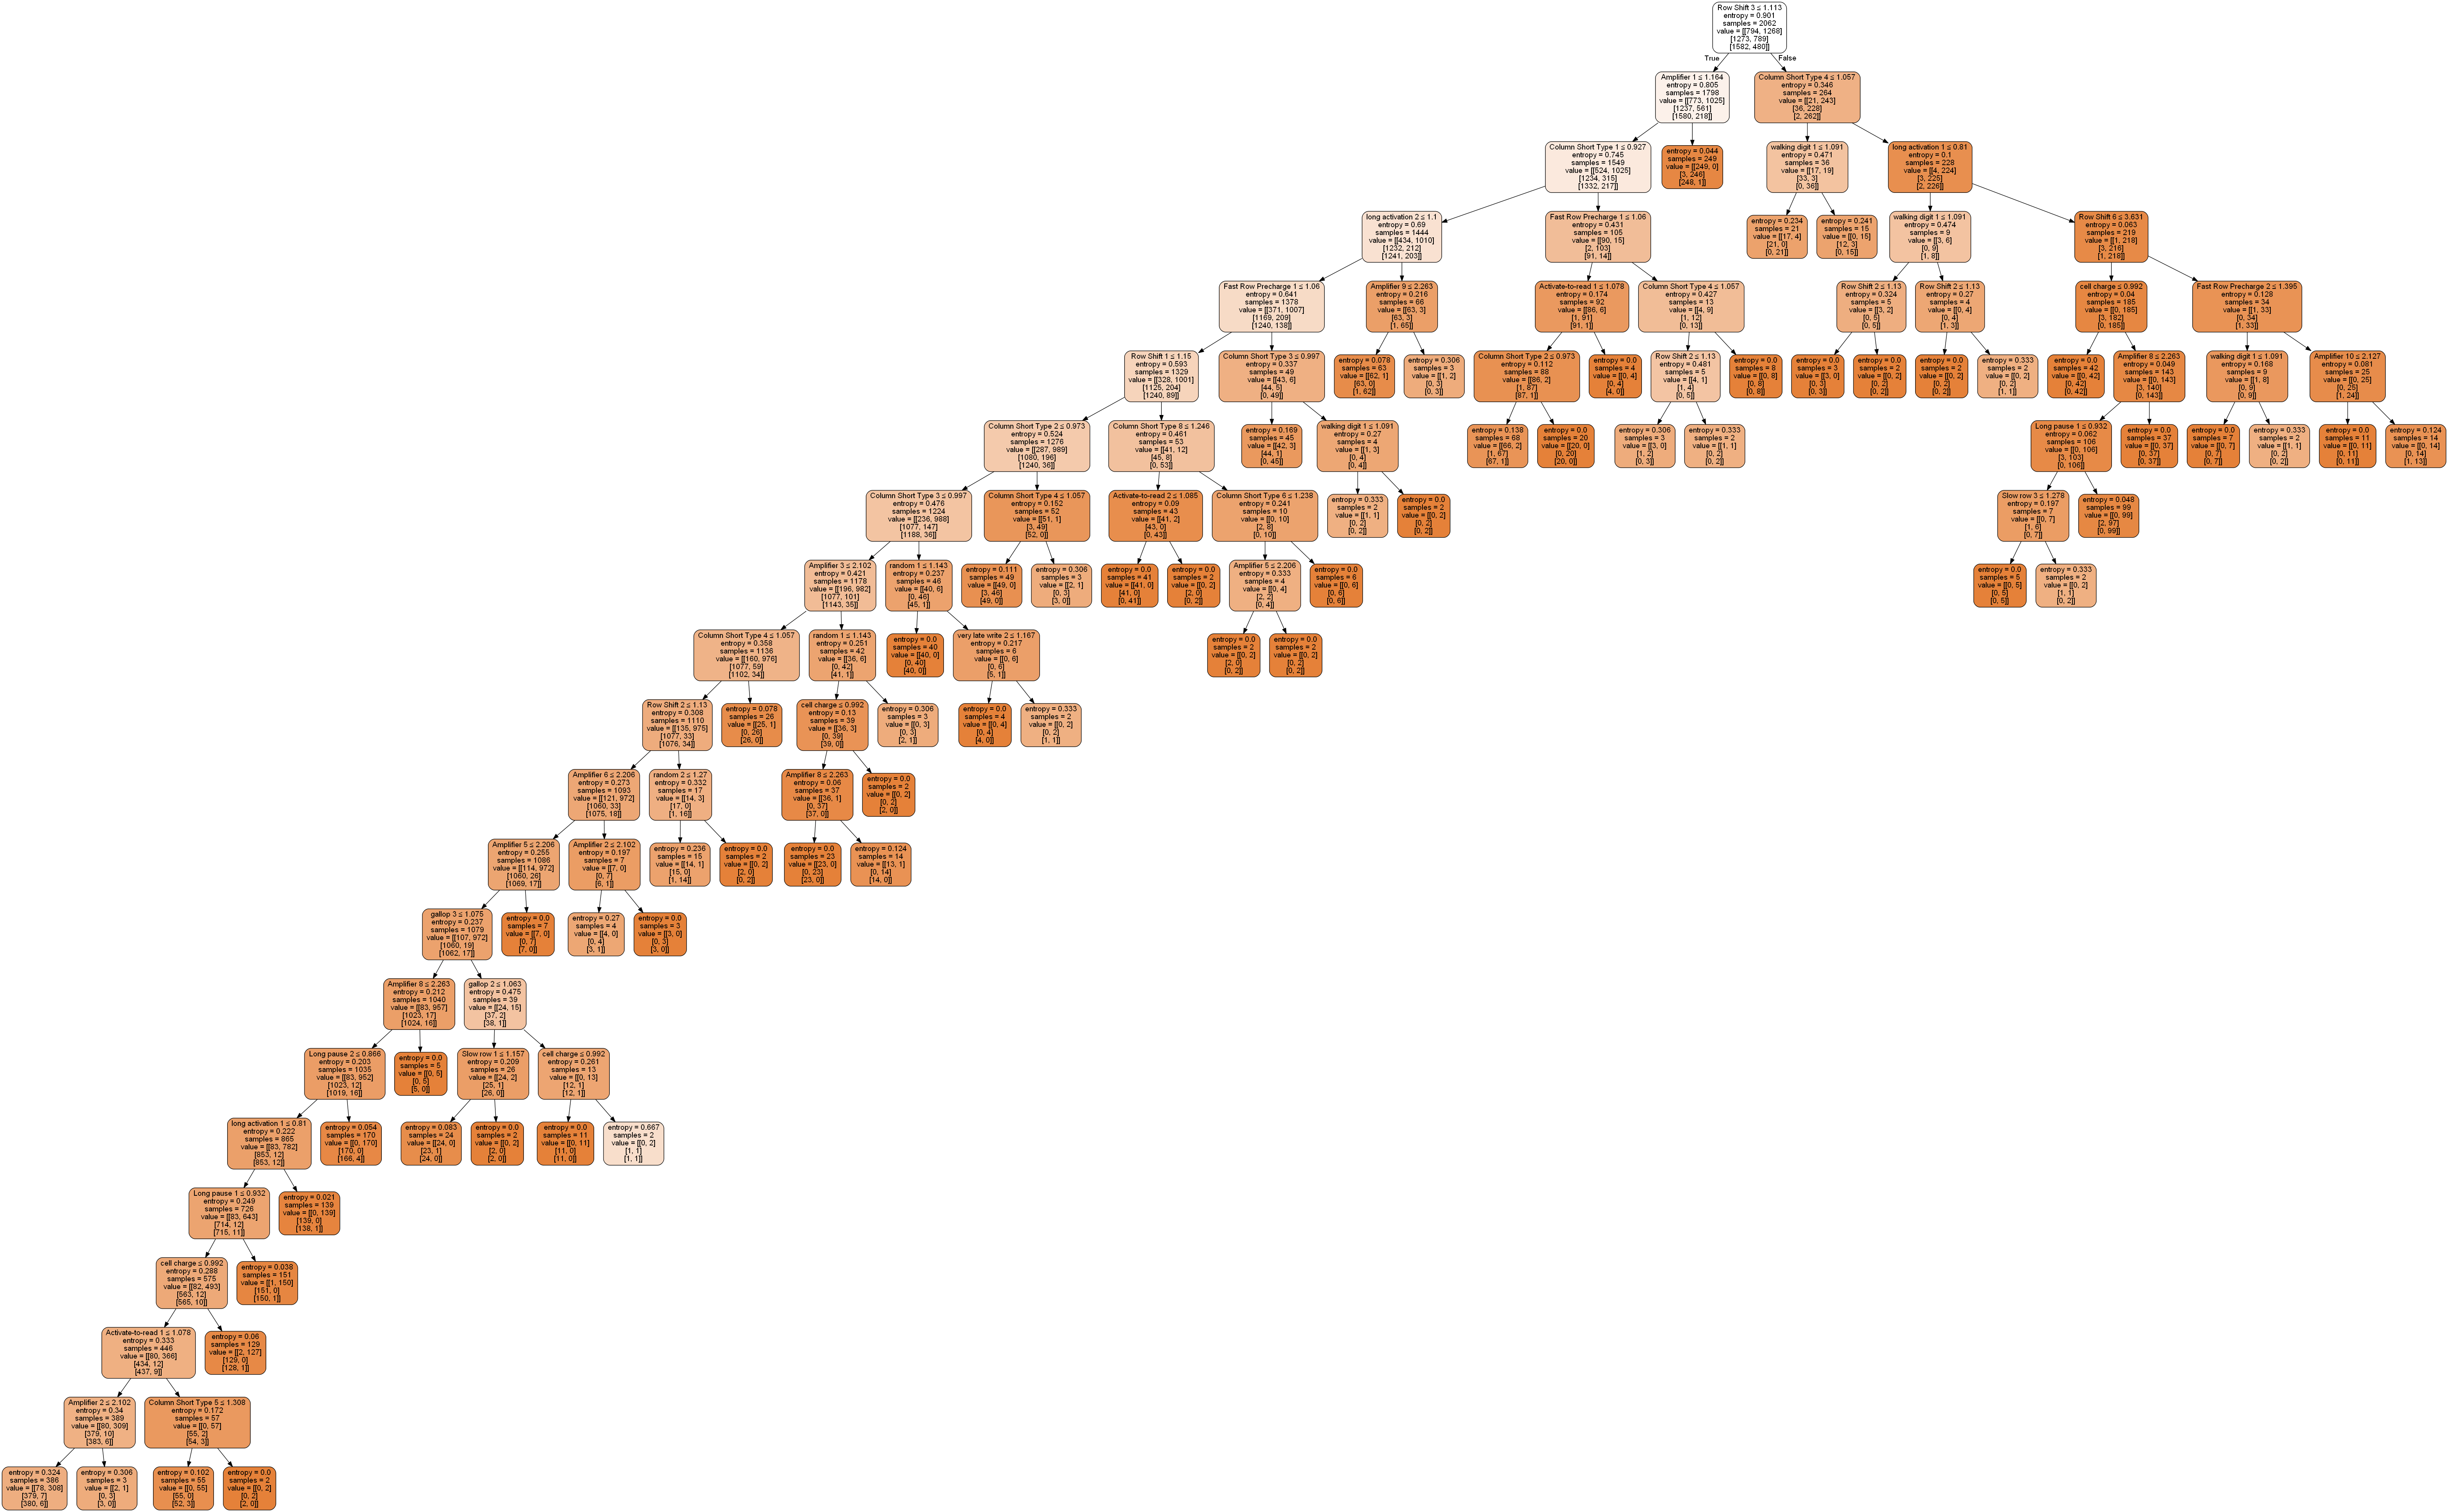

In [59]:
#Section 1.1.2.4 Visualizing the best decision tree so far
#DT visualizatin method 3
#!conda install -y pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#os.environ["PATH"] += os.pathsep + 'C:/Users/boonping/graphviz-2.38/release/bin'

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns,class_names=['Overkill','SB','COL','SB+COL','ROW','ROW+SB','ROW+COL','SB+ROW+COL'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('testClassified.png')
Image(graph.create_png())

In [60]:
#1.1.2.5 Evaluating confusion matrix and accuracy using single decision tree
#multi-class decision tree
y_pred = dt.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix,  multilabel_confusion_matrix  

print(multilabel_confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[[350  46]
  [ 17 618]]

 [[623  14]
  [ 17 377]]

 [[787   4]
  [ 20 220]]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       635
           1       0.96      0.96      0.96       394
           2       0.98      0.92      0.95       240

   micro avg       0.95      0.96      0.95      1269
   macro avg       0.96      0.95      0.95      1269
weighted avg       0.95      0.96      0.95      1269
 samples avg       0.94      0.92      0.93      1269



In [61]:
#1.1.2.6 Printing Feature Importance of a single decision tree
print(dt.feature_importances_)
#print(sorted(dt.feature_importances_))

ranked_feature=[]
leng=len(dt.feature_importances_)
for i in range(leng):
    ranked_feature.append('')
sorted_importance=sorted(dt.feature_importances_)
for i in range( len(dt.feature_importances_) ):
    if dt.feature_importances_[i]>0.20*sorted_importance[-1] or sorted_importance.index(dt.feature_importances_[i]) > len(dt.feature_importances_)-best_depth-1:
        #print(i)
        ranked_feature[leng-1-sorted_importance.index(dt.feature_importances_[i])]=test_data.columns[i+1]
        
for f in ranked_feature:
    if f != "":
        print(f)
    

[8.88251504e-03 8.22967241e-03 6.30677040e-02 5.80789681e-02
 6.94970335e-02 0.00000000e+00 2.10571939e-03 4.84716474e-02
 6.16179434e-03 7.74937091e-03 6.89719245e-03 0.00000000e+00
 5.11098336e-02 1.72706294e-01 0.00000000e+00 5.35610838e-03
 6.03067380e-02 5.95870748e-03 7.32403457e-02 4.97430213e-04
 4.38266063e-04 0.00000000e+00 0.00000000e+00 1.01471827e-02
 2.52310869e-02 1.96658734e-01 8.67684950e-03 0.00000000e+00
 0.00000000e+00 2.59042470e-03 3.88831678e-04 4.02744232e-03
 0.00000000e+00 0.00000000e+00 1.29228270e-03 2.38802531e-03
 4.84006705e-02 6.58773573e-04 0.00000000e+00 1.35807990e-02
 0.00000000e+00 1.24667503e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.01922416e-03 0.00000000e+00 1.11439379e-02 1.25780702e-03
 5.13984086e-03 1.75995708e-04 0.00000000e+00]
Row Shift 2
Column Short Type 3
gallop 2
Row Shift 1
gallop 1
Long pause 2
Fast Row Precharge 1
walking digit 2
Slow row 1
random 2
gallop 3
Column Short Type 6

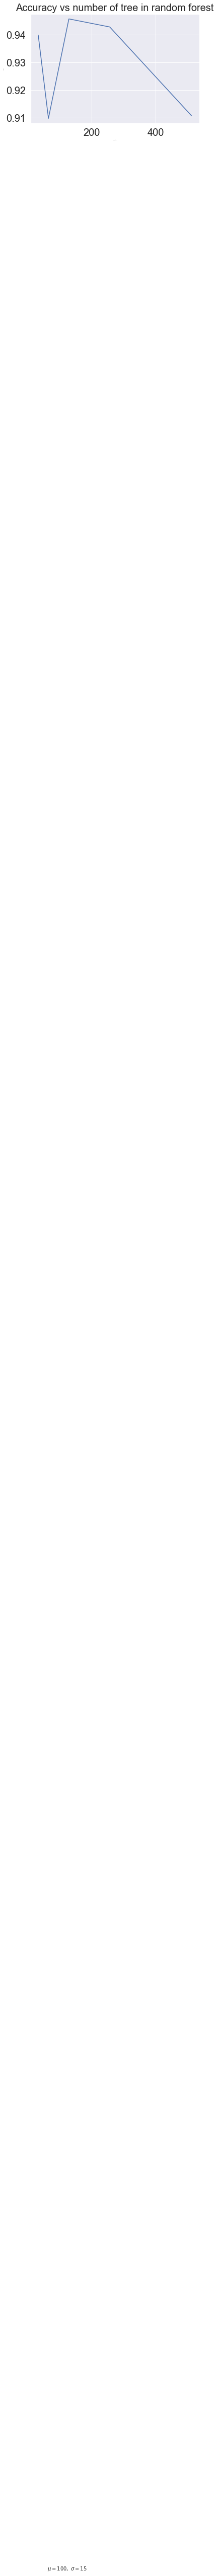

In [62]:
#1.1.3 Develop best single decision tree into random forest for further optimization
from sklearn.ensemble import RandomForestClassifier

#Allow more randomness at random forest. Allow tress to grow deeper.
max_depth=best_depth+15
if max_depth>50:
    max_depth=50

best_num_tree=32
max_score=0
score_arr=[]
for num_trees in [32,64,128,256,512]:    
    dt=eval("RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',\
            max_depth=%s, max_features='auto', max_leaf_nodes=None,\
            min_impurity_decrease=%s, min_impurity_split=None,\
            min_samples_leaf=1, min_samples_split=2,\
            min_weight_fraction_leaf=%s, n_estimators=%s, n_jobs=None,\
            oob_score=False, random_state=0, verbose=0, warm_start=False)" % (max_depth,best_impurity_decrease,best_weight_fraction_leaf,num_trees) )

    dt.fit(X_train, y_train)   
    if dt.score(X_test, y_test)>max_score:
        max_score=dt.score(X_test, y_test)
        best_num_tree=num_trees
    score_arr.append(dt.score(X_test, y_test))
    
plt.xlabel('number of tree')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of tree in random forest')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.plot([32,64,128,256,512], score_arr)
plt.grid(True)
plt.show()
#print("best_num_tree:")


In [63]:
#Final Random Forest 
dt=eval("RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',\
        max_depth=%s, max_features='auto', max_leaf_nodes=None,\
        min_impurity_decrease=%s, min_impurity_split=None,\
        min_samples_leaf=1, min_samples_split=2,\
        min_weight_fraction_leaf=%s, n_estimators=%s, n_jobs=None,\
        oob_score=False, random_state=0, verbose=0, warm_start=False)" % (max_depth,best_impurity_decrease,best_weight_fraction_leaf,best_num_tree) )
dt.fit(X_train, y_train)   

'''
#allow visualization on each tree
for i in range(len(dt.estimators_)):
    print("tree %s" % i )
    #print(dt.estimators_[i])
    #post pruning each tree
    #prune_duplicate_leaves(dt.estimators_[i])
    #print(dt.estimators_[i])
'''

print("Random forest info:")
print(dt)
print("max depth: {:d}".format(max_depth))
print("selected best_impurity_decrease: {:.8f}".format(best_impurity_decrease))
print("selected best_weight_fraction_leaf: {:.8f}".format(best_weight_fraction_leaf))
print("Accuracy on training set (multilabel): {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set(multilabel): {:.3f}".format(dt.score(X_test, y_test)))

#print(dt.predict(X_test))
#raise

Random forest info:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=36, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0008, n_estimators=128,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
max depth: 36
selected best_impurity_decrease: 0.00010000
selected best_weight_fraction_leaf: 0.00080000
Accuracy on training set (multilabel): 0.971
Accuracy on test set(multilabel): 0.946


In [64]:
#Section 2: SVC

In [65]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
#scaler = StandardScaler()  
#scaler.fit(X_train) 
#X_train= scaler.transform(X_train)  
#X_test2= scaler.transform(X_test2) 
#svm=SVC(kernel="rbf", gamma=10, C=1) 
#loop set up to determine optimum value for C

#To avoid exhaustive grid search, Find best C_val in range of 1 to 10.
max_score = 0
optimal_C = 0
for C_val in range(1,10,1):
    #svm=OneVsRestClassifier( SVC(kernel="rbf", gamma='auto_deprecated', C=C_val)  )
    svm=OneVsRestClassifier( SVC(kernel="linear", gamma='auto_deprecated', C=C_val)  )
    svm.fit(X_train, y_train)
    predictions = svm.predict(X_test2)
    if svm.score(X_train, y_train) > max_score:
        max_score = svm.score(X_train, y_train)
        optimal_C = C_val
    print("++++++++++++++++++++++++++++++++++++++++++++")
    
    #print(predictions)
    #print("++++++++++++++++++++++++++++++++++++++++++++")
    from sklearn.metrics import classification_report, confusion_matrix 
    print("C= ", C_val)
    print(multilabel_confusion_matrix(y_test,predictions))  
    print(classification_report(y_test,predictions)) 
    print("Accuracy on training set: {:.3f}".format(svm.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(svm.score(X_test2, y_test)))
    print("============================================")
    print(predictions)
print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
print("optimal C = ", optimal_C)

#compute the best SVC with optimal C value.
svm_single=SVC(kernel="linear", gamma='auto_deprecated', C=optimal_C, probability=True) 
svm=OneVsRestClassifier( SVC(kernel="linear", gamma='auto_deprecated', C=optimal_C, probability=True)  )
#svm=OneVsRestClassifier( SVC(kernel="rbf", gamma='auto_deprecated', C=optimal_C)  )
svm.fit(X_train, y_train)
predictions = svm.predict(X_test2)
svm_pred=predictions


                                     
                                     

++++++++++++++++++++++++++++++++++++++++++++
C=  1
[[[393   3]
  [  6 629]]

 [[626  11]
  [  6 388]]

 [[787   4]
  [ 10 230]]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       635
           1       0.97      0.98      0.98       394
           2       0.98      0.96      0.97       240

   micro avg       0.99      0.98      0.98      1269
   macro avg       0.98      0.98      0.98      1269
weighted avg       0.99      0.98      0.98      1269
 samples avg       0.94      0.94      0.94      1269

Accuracy on training set: 0.975
Accuracy on test set: 0.961
[[0 1 0]
 [0 1 0]
 [1 1 1]
 ...
 [1 0 0]
 [1 0 0]
 [1 1 1]]
++++++++++++++++++++++++++++++++++++++++++++
C=  2
[[[393   3]
  [  6 629]]

 [[625  12]
  [  4 390]]

 [[787   4]
  [ 10 230]]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       635
           1       0.97      0.99      0.98       394
           2       0.98 

In [66]:
#Debugging purpose. Ignored
from sklearn.ensemble import VotingClassifier,BaggingClassifier
from sklearn.neural_network import MLPClassifier

'''
mlp=MLPClassifier(activation='logistic', alpha=0.9920073082747223,
              batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=True,
              epsilon=1e-08)
mlp.fit(X_train, y_train)
print(mlp)

#print(dt.predict(X_test))

print(svm)

#print(svm.predict(X_test))
#Extracting ROW/COL/SB y and predict result from multilabel array as sklearn metrics may not support multilabel for bagging classifier.
y_train_row=[]
y_test_row=[]
dt_pred_row=[]
svm_pred_row=[]
mlp_pred_row=[]
for elem in y_train:
    y_train_row.append(elem[0])
for elem in y_test:    
    y_test_row.append(elem[0])
for elem in dt.predict(X_test):    
    dt_pred_row.append(elem[0])
for elem in svm.predict(X_test):    
    svm_pred_row.append(elem[0])
for elem in mlp.predict(X_test):    
    mlp_pred_row.append(elem[0])
    
y_train_col=[]
y_test_col=[]
dt_pred_col=[]
svm_pred_col=[]
mlp_pred_col=[]
for elem in y_train:
    y_train_col.append(elem[1])
for elem in y_test:    
    y_test_col.append(elem[1])
for elem in dt.predict(X_test):    
    dt_pred_col.append(elem[1])
for elem in svm.predict(X_test):    
    svm_pred_col.append(elem[1])
for elem in mlp.predict(X_test):    
    mlp_pred_col.append(elem[1])
    
y_train_sb=[]
y_test_sb=[]
dt_pred_sb=[]
svm_pred_sb=[]
mlp_pred_sb=[]
for elem in y_train:
    y_train_sb.append(elem[2])
for elem in y_test:    
    y_test_sb.append(elem[2])
for elem in dt.predict(X_test):    
    dt_pred_sb.append(elem[2])
for elem in svm.predict(X_test):    
    svm_pred_sb.append(elem[2])
for elem in mlp.predict(X_test):    
    mlp_pred_sb.append(elem[2])
        
#print(y_train_row)
false_pass_count=[
    confusion_matrix(y_test_row,dt_pred_row )[1][0] + confusion_matrix(y_test_col,dt_pred_col )[1][0] + confusion_matrix(y_test_sb,dt_pred_sb )[1][0],
    confusion_matrix(y_test_row,svm_pred_row )[1][0] + confusion_matrix(y_test_col,svm_pred_col )[1][0] + confusion_matrix(y_test_sb,svm_pred_sb )[1][0],
    confusion_matrix(y_test_row,mlp_pred_row ) [1][0] + confusion_matrix(y_test_col,mlp_pred_col )[1][0] + confusion_matrix(y_test_sb,mlp_pred_sb )[1][0]
]

#print(false_pass_count[0])
    

dt_row=dt.fit(X_train,y_train_row)
dt_col=dt.fit(X_train,y_train_col)
dt_sb=dt.fit(X_train,y_train_sb)


mlp_row=mlp.fit(X_train,y_train_row)
mlp_col=mlp.fit(X_train,y_train_col)
mlp_sb=mlp.fit(X_train,y_train_sb)

svm_row=svm_single.fit(X_train,y_train_row)
svm_col=svm_single.fit(X_train,y_train_col)
svm_sb=svm_single.fit(X_train,y_train_sb)


for i in range(3):
    if max(false_pass_count)==false_pass_count[i]:
        if i==1:
            dt2=eval("RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',\
            max_depth=%s, max_features='auto', max_leaf_nodes=None,\
            min_impurity_decrease=%s, min_impurity_split=None,\
            min_samples_leaf=1, min_samples_split=2,\
            min_weight_fraction_leaf=%s, n_estimators=50, n_jobs=None,\
            oob_score=False, random_state=0, verbose=0, warm_start=False)" % (best_depth,best_impurity_decrease,best_weight_fraction_leaf) )
            dt_row2=dt2.fit(X_train,y_train_row)
            dt_col2=dt2.fit(X_train,y_train_col)
            dt_sb2=dt2.fit(X_train,y_train_sb)
            dt_row=dt.fit(X_train,y_train_row)
            dt_col=dt.fit(X_train,y_train_col)
            dt_sb=dt.fit(X_train,y_train_sb)            
            
            if dt_row2.score(X_test,y_test_row)>dt_row.score(X_test,y_test_row):
                if dt_col2.score(X_test,y_test_col)>dt_col.score(X_test,y_test_col):
                    if dt_sb2.score(X_test,y_test_sb)>dt_sb.score(X_test,y_test_sb):
                        print("changed dt")
                        dt=dt2
                        dt.fit(X_train,y_train)
            dt_row=dt.fit(X_train,y_train_row)
            dt_col=dt.fit(X_train,y_train_col)
            dt_sb=dt.fit(X_train,y_train_sb)
        elif i==2:
            svm2=BaggingClassifier(base_estimator=svm, n_estimators=10)
            svm_row2=svm2.fit(X_train,y_train_row)
            svm_col2=svm2.fit(X_train,y_train_col)
            svm_sb2=svm2.fit(X_train,y_train_sb)
            svm_row=svm_single.fit(X_train,y_train_row)
            svm_col=svm_single.fit(X_train,y_train_col)
            svm_sb=svm_single.fit(X_train,y_train_sb)            
            if svm_row2.score(X_test,y_test_row)>svm_row.score(X_test,y_test_row):
                if svm_col2.score(X_test,y_test_col)>svm_col.score(X_test,y_test_col):
                    if svm_sb2.score(X_test,y_test_sb)>svm_sb.score(X_test,y_test_sb):
                        print("changed svm")
                        svm=svm2         
            svm_row=svm.fit(X_train,y_train_row)
            svm_col=svm.fit(X_train,y_train_col)
            svm_sb=svm.fit(X_train,y_train_sb)
                        
        elif i==3:
            mlp2=BaggingClassifier(base_estimator=mlp, n_estimators=10)
            mlp_row2=mlp2.fit(X_train,y_train_row)
            mlp_col2=mlp2.fit(X_train,y_train_col)
            mlp_sb2=mlp2.fit(X_train,y_train_sb)
            mlp_row=mlp.fit(X_train,y_train_row)
            mlp_col=mlp.fit(X_train,y_train_col)
            mlp_sb=mlp.fit(X_train,y_train_sb)
            if mlp_row2.score(X_test,y_test_row)>mlp_row.score(X_test,y_test):
                if mlp_col2.score(X_test,y_test_col)>mlp_col.score(X_test,y_test):
                    if mlp_sb2.score(X_test,y_test_sb)>mlp_sb.score(X_test,y_test):
                        print("changed mlp")
                        mlp=mlp2
                        #mlp.fit(X_train,y_train)            
            mlp_row=mlp.fit(X_train,y_train_row)
            mlp_col=mlp.fit(X_train,y_train_col)
            mlp_sb=mlp.fit(X_train,y_train_sb)
        break

print(dt)
print(svm)
print(mlp)

            


#print (mlp_row.predict(X_test))
#VoteSysRow=VotingClassifier(estimators=[('first', dt_row), ('second',svm_row ),('third',mlp_row) ], voting='soft')
VoteSysRow=VotingClassifier(estimators=[('first', dt_row), ('second',svm_row ),('third',mlp_row) ], voting='soft')



print("%s" % VoteSysRow)
#print(y_test_row)
VoteSysRow=VoteSysRow.fit(X_train, y_train_row)


FinalPred = VoteSysRow.predict(X_test)
  
          


FinalPredProba = VoteSysRow.predict_proba(X_test)
print(confusion_matrix(y_test_row,FinalPred))  
print(classification_report(y_test_row,FinalPred)) 

print(VoteSysRow.score(X_test,y_test_row))  


raise
'''
                           


'\nmlp=MLPClassifier(activation=\'logistic\', alpha=0.9920073082747223,\n              batch_size=\'auto\', beta_1=0.9, beta_2=0.999, early_stopping=True,\n              epsilon=1e-08)\nmlp.fit(X_train, y_train)\nprint(mlp)\n\n#print(dt.predict(X_test))\n\nprint(svm)\n\n#print(svm.predict(X_test))\n#Extracting ROW/COL/SB y and predict result from multilabel array as sklearn metrics may not support multilabel for bagging classifier.\ny_train_row=[]\ny_test_row=[]\ndt_pred_row=[]\nsvm_pred_row=[]\nmlp_pred_row=[]\nfor elem in y_train:\n    y_train_row.append(elem[0])\nfor elem in y_test:    \n    y_test_row.append(elem[0])\nfor elem in dt.predict(X_test):    \n    dt_pred_row.append(elem[0])\nfor elem in svm.predict(X_test):    \n    svm_pred_row.append(elem[0])\nfor elem in mlp.predict(X_test):    \n    mlp_pred_row.append(elem[0])\n    \ny_train_col=[]\ny_test_col=[]\ndt_pred_col=[]\nsvm_pred_col=[]\nmlp_pred_col=[]\nfor elem in y_train:\n    y_train_col.append(elem[1])\nfor elem in y_

In [67]:
#Section 3: MLP

In [68]:
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, roc_curve, auc
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.multiclass import OneVsRestClassifier, _fit_binary
from itertools import cycle, product
from sklearn.manifold import TSNE
import seaborn as sns
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic
import time
#from sklearn.externals.joblib import Parallel, delayed
from sklearn.ensemble import VotingClassifier
from joblib import Parallel, delayed

#Section 3.0 data preprossing

# Reading the data
failure = pd.read_csv('TargetData.csv')

# Inspecting the data
pd.options.display.max_rows = 1000
print(failure.shape)
print(failure.head(3).transpose()) # 3093 data points with 1 ID, 58 features and 5 targets
print(failure.describe().transpose()) # 3 features do not have any variance: 'gallop 1','gallop 5','Row Shift 7'

(3093, 64)
                                      0                  1                  2
ID                    076269B:09:N06:35  076269B:08:N02:23  076269B:09:P01:52
cell charge                           1                  0                  1
long activation 1                     0                  0                  1
gallop 1                              0                  0                  0
Fast Row Precharge 1                  0                  0                  1
Row Shift 1                           0                  0                  1
Column Short Type 1                   0                  0                  1
very late write 1                     0                  0                  1
Slow row 1                            0                  0                  1
Column Short Type 2                   0                  0                  1
Long pause 1                          0                  0                  1
Activate-to-read 1                    0              

ROW                   3093.0  0.232784  0.422674  0.0  0.0  0.0  0.0  1.0


In [69]:
# Set up the data and label
#X consists of 58 features. Each feature represents 1 test in the long test flow.
X = failure.drop(['ID', 'gallop 1', 'gallop 5', 'Row Shift 7', 'SB','COL', 'Margin', 'Block', 'ROW'], axis=1)
#Y can be one of ROW,COL,SB. ROW means the failure is on a row of memory array.
#COL means the failure is on a column of the cell array
#SB is single bit failure inside the memory
#Forming 8 class from 3 columns, coded as 0 to 7
#['Overkill','SB','COL','SB+COL','ROW','ROW+SB','ROW+COL','SB+ROW+COL']
  #y = failure.SB+2*failure.COL+4*failure.ROW

#Converting y to reflect multilabels
  #mlb = MultiLabelBinarizer()
  #y_converted = mlb.fit_transform(failure[['SB','COL','ROW']])

target = ['multilabels', 'SB', 'ROW', 'COL']
y = [None] * len(target)

y[0] = failure[['SB', 'ROW', 'COL']].values
n_classes = y[0].shape[1]

for (i, j) in zip(range(1, len(target)), ['SB', 'ROW', 'COL']):
    y[i] = failure[j].values

In [70]:
#Section 3.1 t-SNE model
# Runnig the t-SNE model
i = ['SB', 'ROW', 'COL'] 

for i in i:
    failure[i] = failure[i].replace({0: 'Negative', 1: 'Positive'})

# Create a t-SNE model with learning rate 50
embedding = TSNE(n_components=2,
                 perplexity=30,
                 learning_rate=200.0,
                 verbose=10,
                 random_state=42)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = pd.DataFrame(embedding.fit_transform(X))

tsne_features_failure = tsne_features.join([failure['SB'], failure['ROW'], failure['COL']])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3093 samples in 0.028s...
[t-SNE] Computed neighbors for 3093 samples in 0.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3093
[t-SNE] Computed conditional probabilities for sample 2000 / 3093
[t-SNE] Computed conditional probabilities for sample 3000 / 3093
[t-SNE] Computed conditional probabilities for sample 3093 / 3093
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.388s
[t-SNE] Iteration 50: error = 62.4724350, gradient norm = 0.0729481 (50 iterations in 1.652s)
[t-SNE] Iteration 100: error = 51.2578964, gradient norm = 0.0308795 (50 iterations in 0.928s)
[t-SNE] Iteration 150: error = 47.4513092, gradient norm = 0.0306882 (50 iterations in 0.861s)
[t-SNE] Iteration 200: error = 45.6535110, gradient norm = 0.0292443 (50 iterations in 0.899s)
[t-SNE] Iteration 250: error = 44.5002403, gradient norm = 0.0122209 (50 iterations in 0.913s)
[t-SNE] KL divergence after 250 iterati

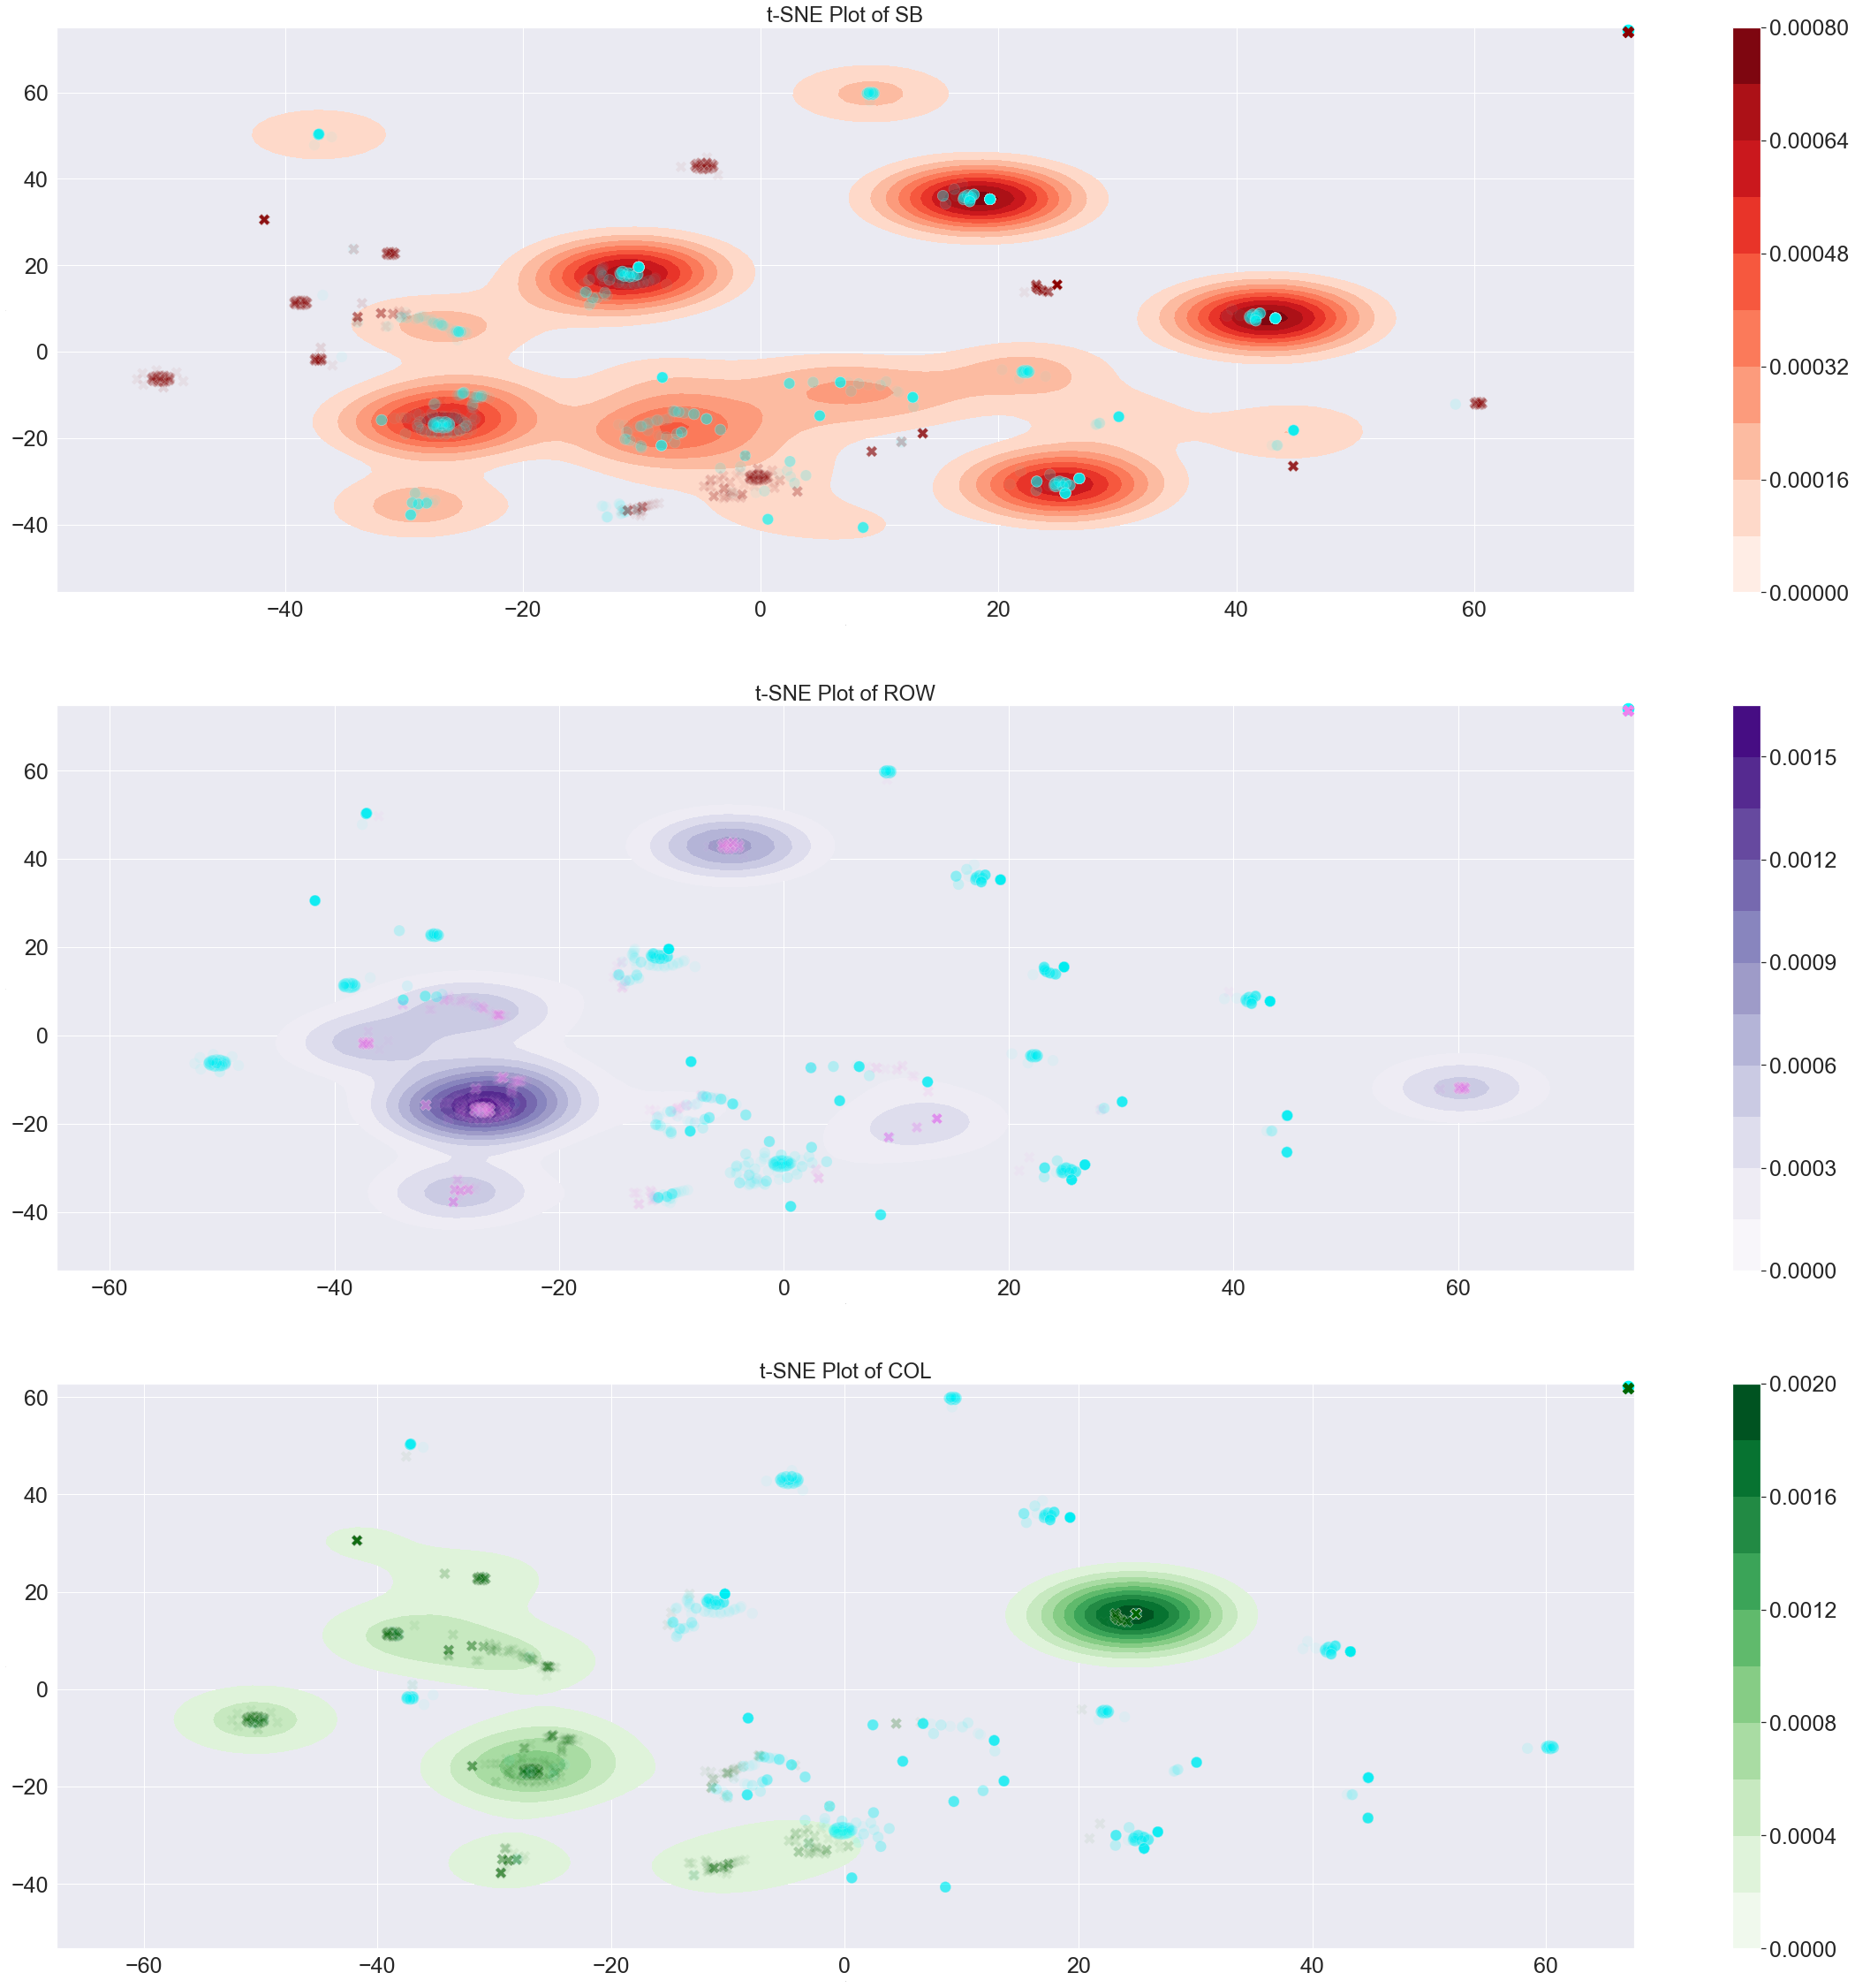

In [71]:
# Color the points according to types of failure
sns.set(rc={'figure.figsize': (40,40), 'legend.fontsize': 0, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
            'lines.markersize': 12.5, 'axes.labelsize': 0, 'axes.titlesize': 24})

fig, ax = plt.subplots(3,1)

j = ['SB', 'ROW', 'COL']
k = ['Reds', 'Purples', 'Greens']
l = ['darkred', 'violet', 'darkgreen']

for (i, j, k, l) in zip(range(n_classes), j, k, l):
    
    ax[i].set_title('t-SNE Plot of {}'.format(j))
    
    sns.kdeplot(data=tsne_features_failure[tsne_features_failure[j] == 'Positive'][0],
                data2=tsne_features_failure[tsne_features_failure[j] == 'Positive'][1],
                cmap=k,
                shade=True,
                shade_lowest=False,
                bw=5,
                cbar=True, 
                ax=ax[i])
    
    sns.scatterplot(x=tsne_features_failure[0],
                    y=tsne_features_failure[1],
                    hue=tsne_features_failure[j],
                    style=tsne_features_failure[j],
                    palette=['aqua', l],
                    alpha=0.05,
                    ax=ax[i])

100%|████████████████████████████████████████████████| 100/100 [00:26<00:00,  4.10it/s, best loss: 0.04316246911072741]
multilabels----------
                                                                    
activation              relu      relu      relu      relu      relu
alpha                5.09125   9.05343   9.04263   8.99538   10.6554
hidden_layer_sizes         9         9         9         9         9
learning_rate       constant  constant  constant  constant  constant
learning_rate_init  0.517184  0.206775  0.372393  0.375619  0.334551
power_t             0.476885  0.245945  0.369772   0.97774  0.048474
solver                 lbfgs     lbfgs     lbfgs     lbfgs     lbfgs
best_score          0.956838  0.948593  0.947622  0.947138  0.946167
__________
100%|███████████████████████████████████████████████| 100/100 [00:08<00:00,  7.73it/s, best loss: 0.012122290776775846]
SB----------
                                                                            
activation      

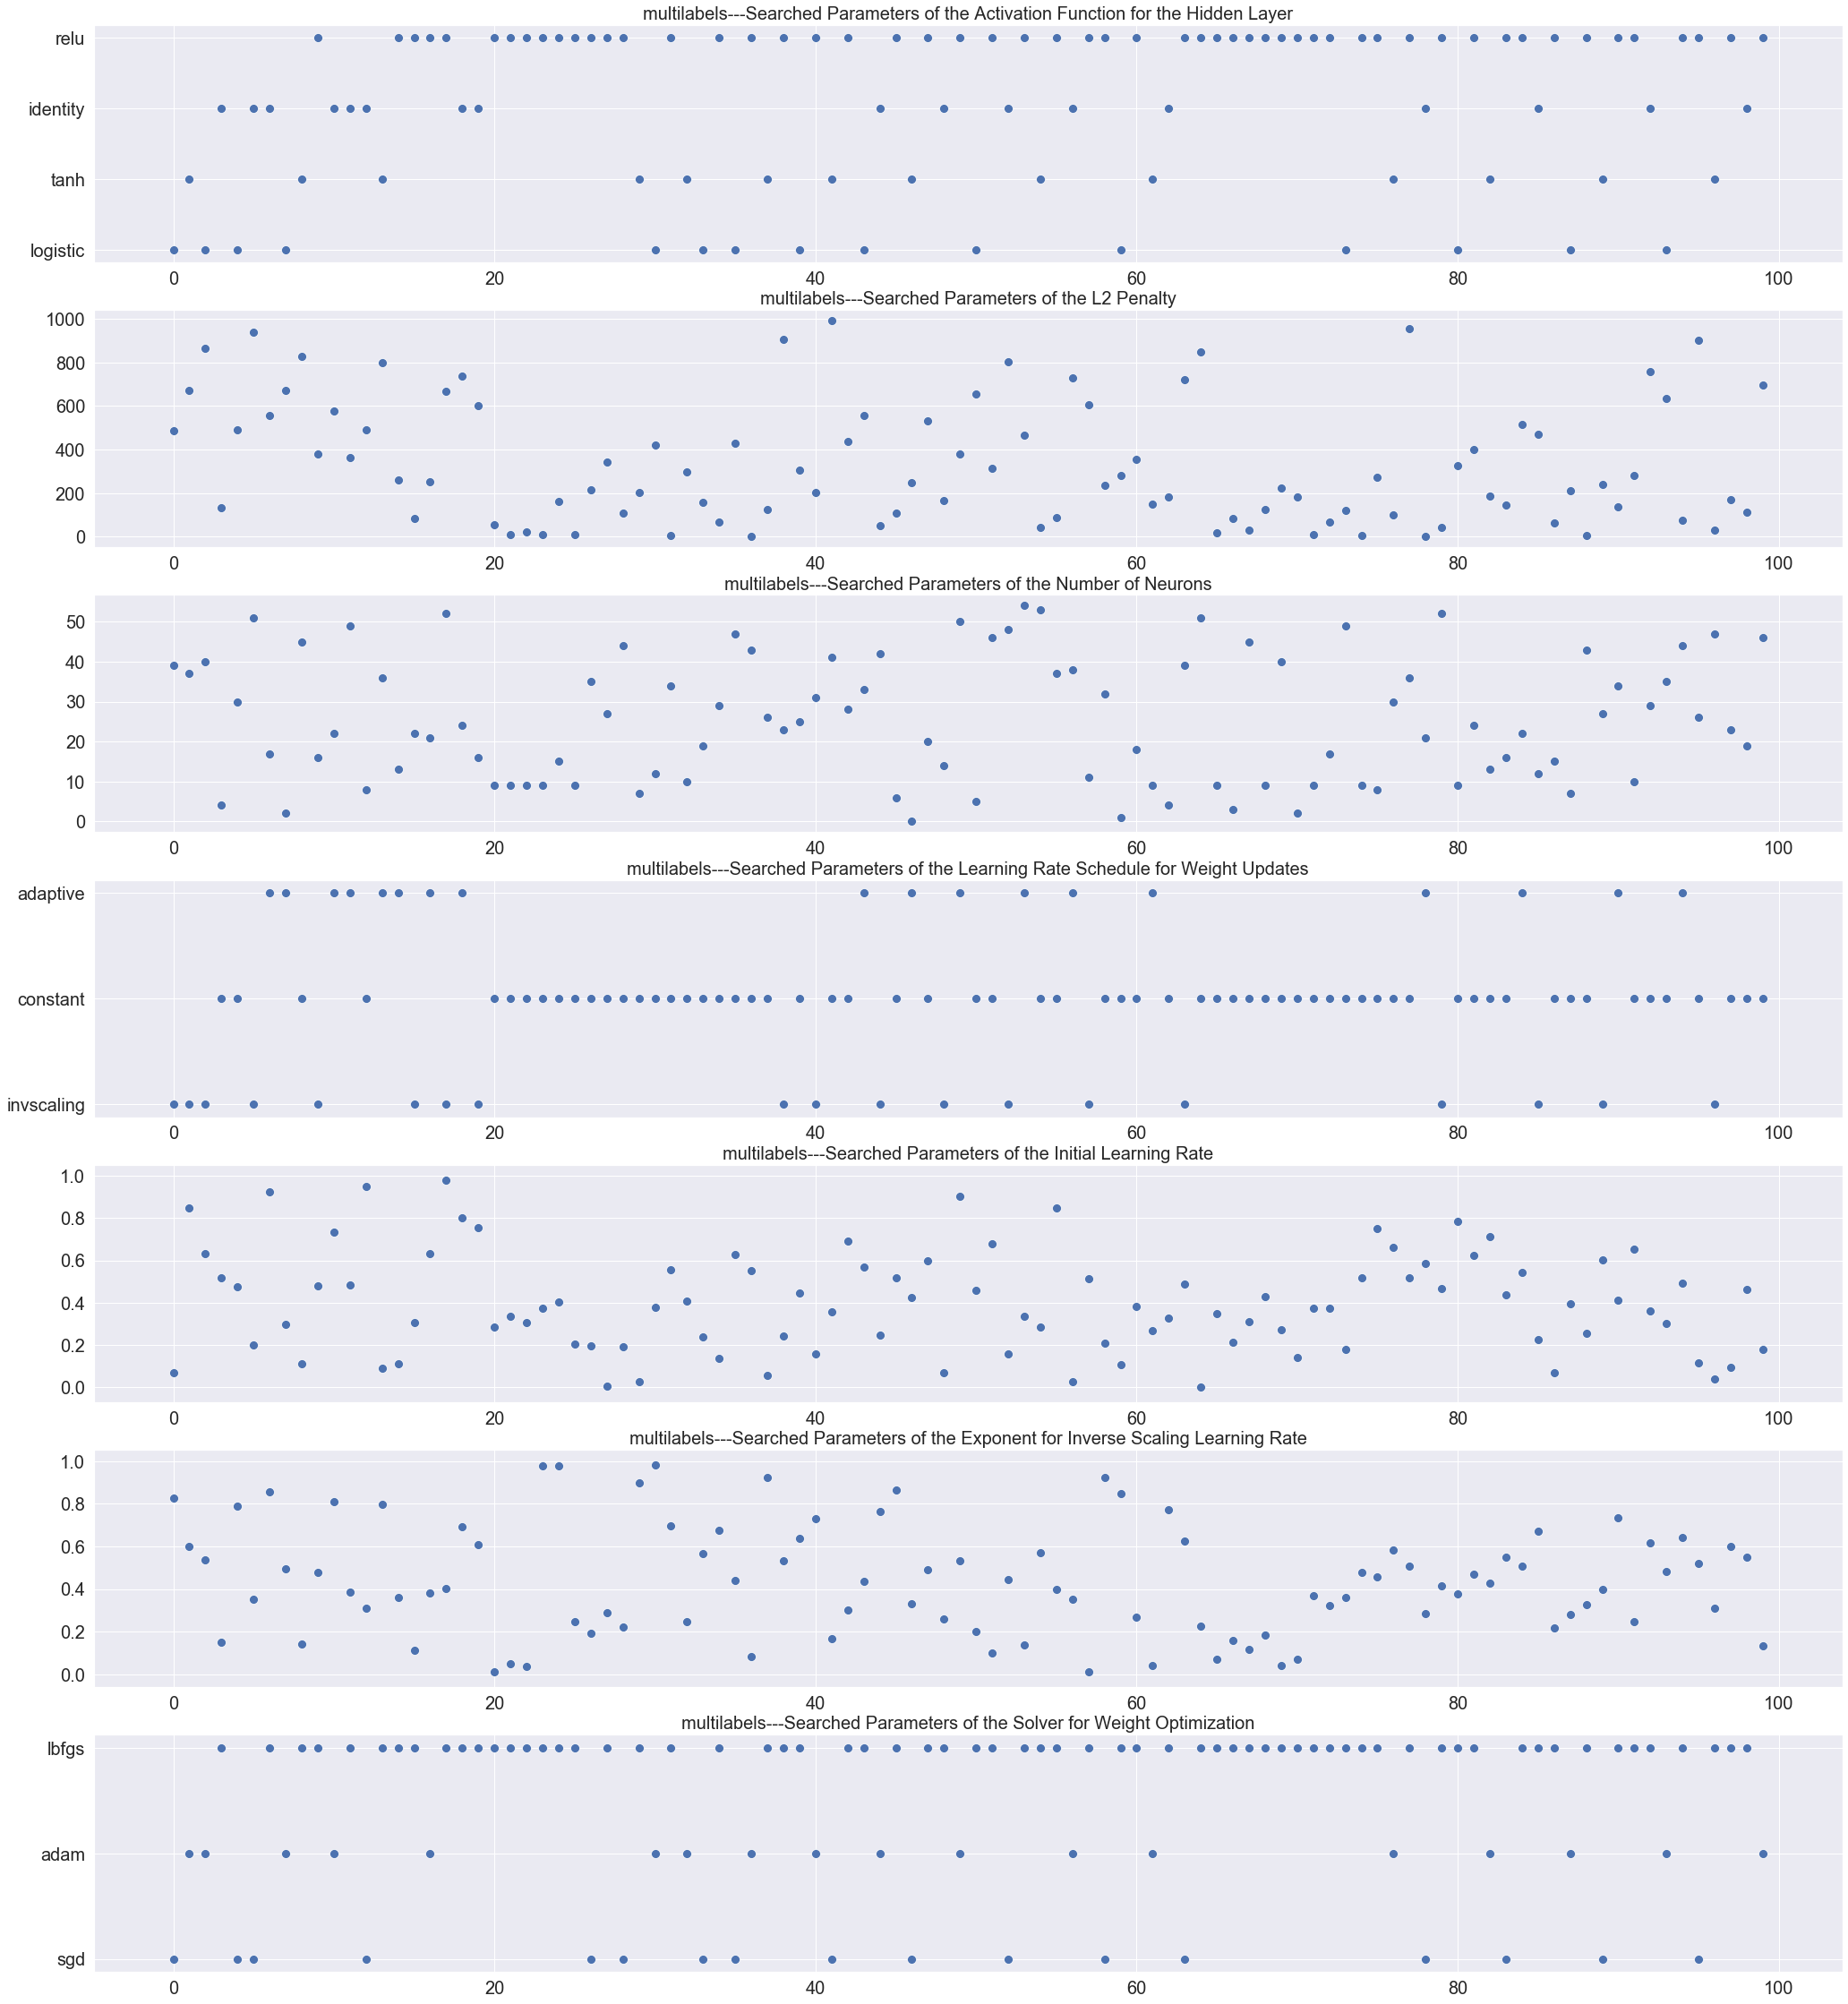

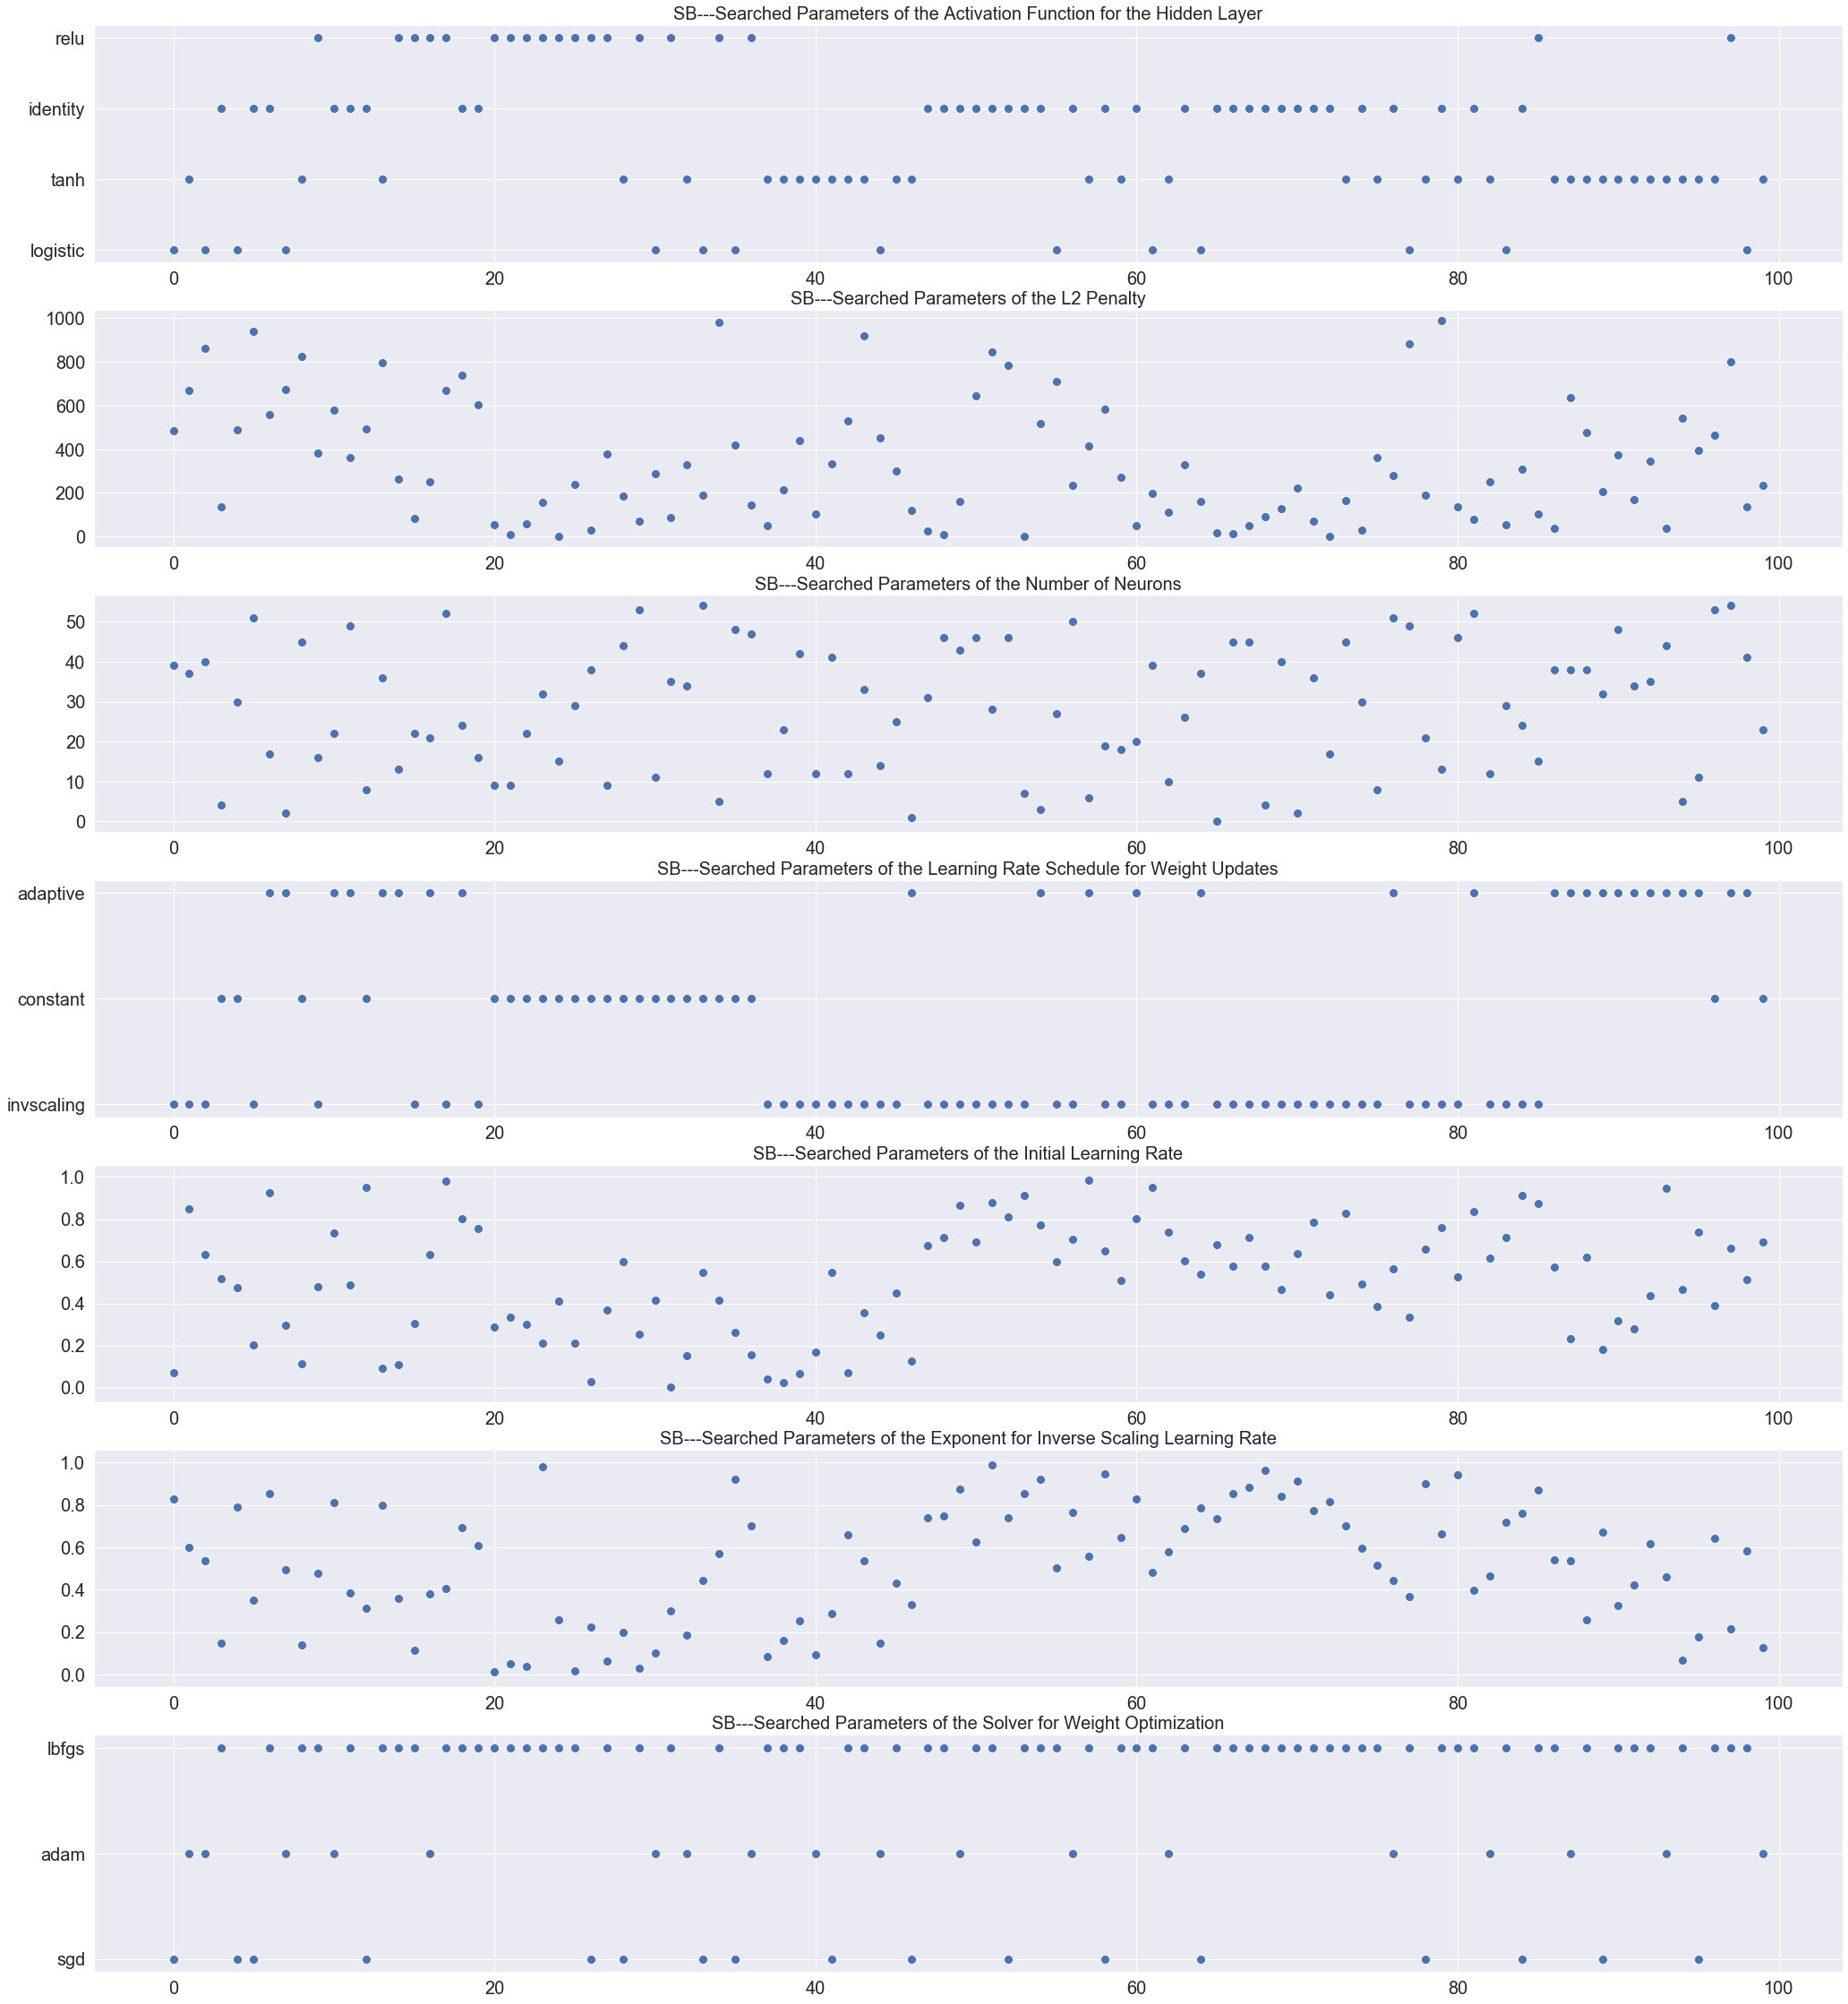

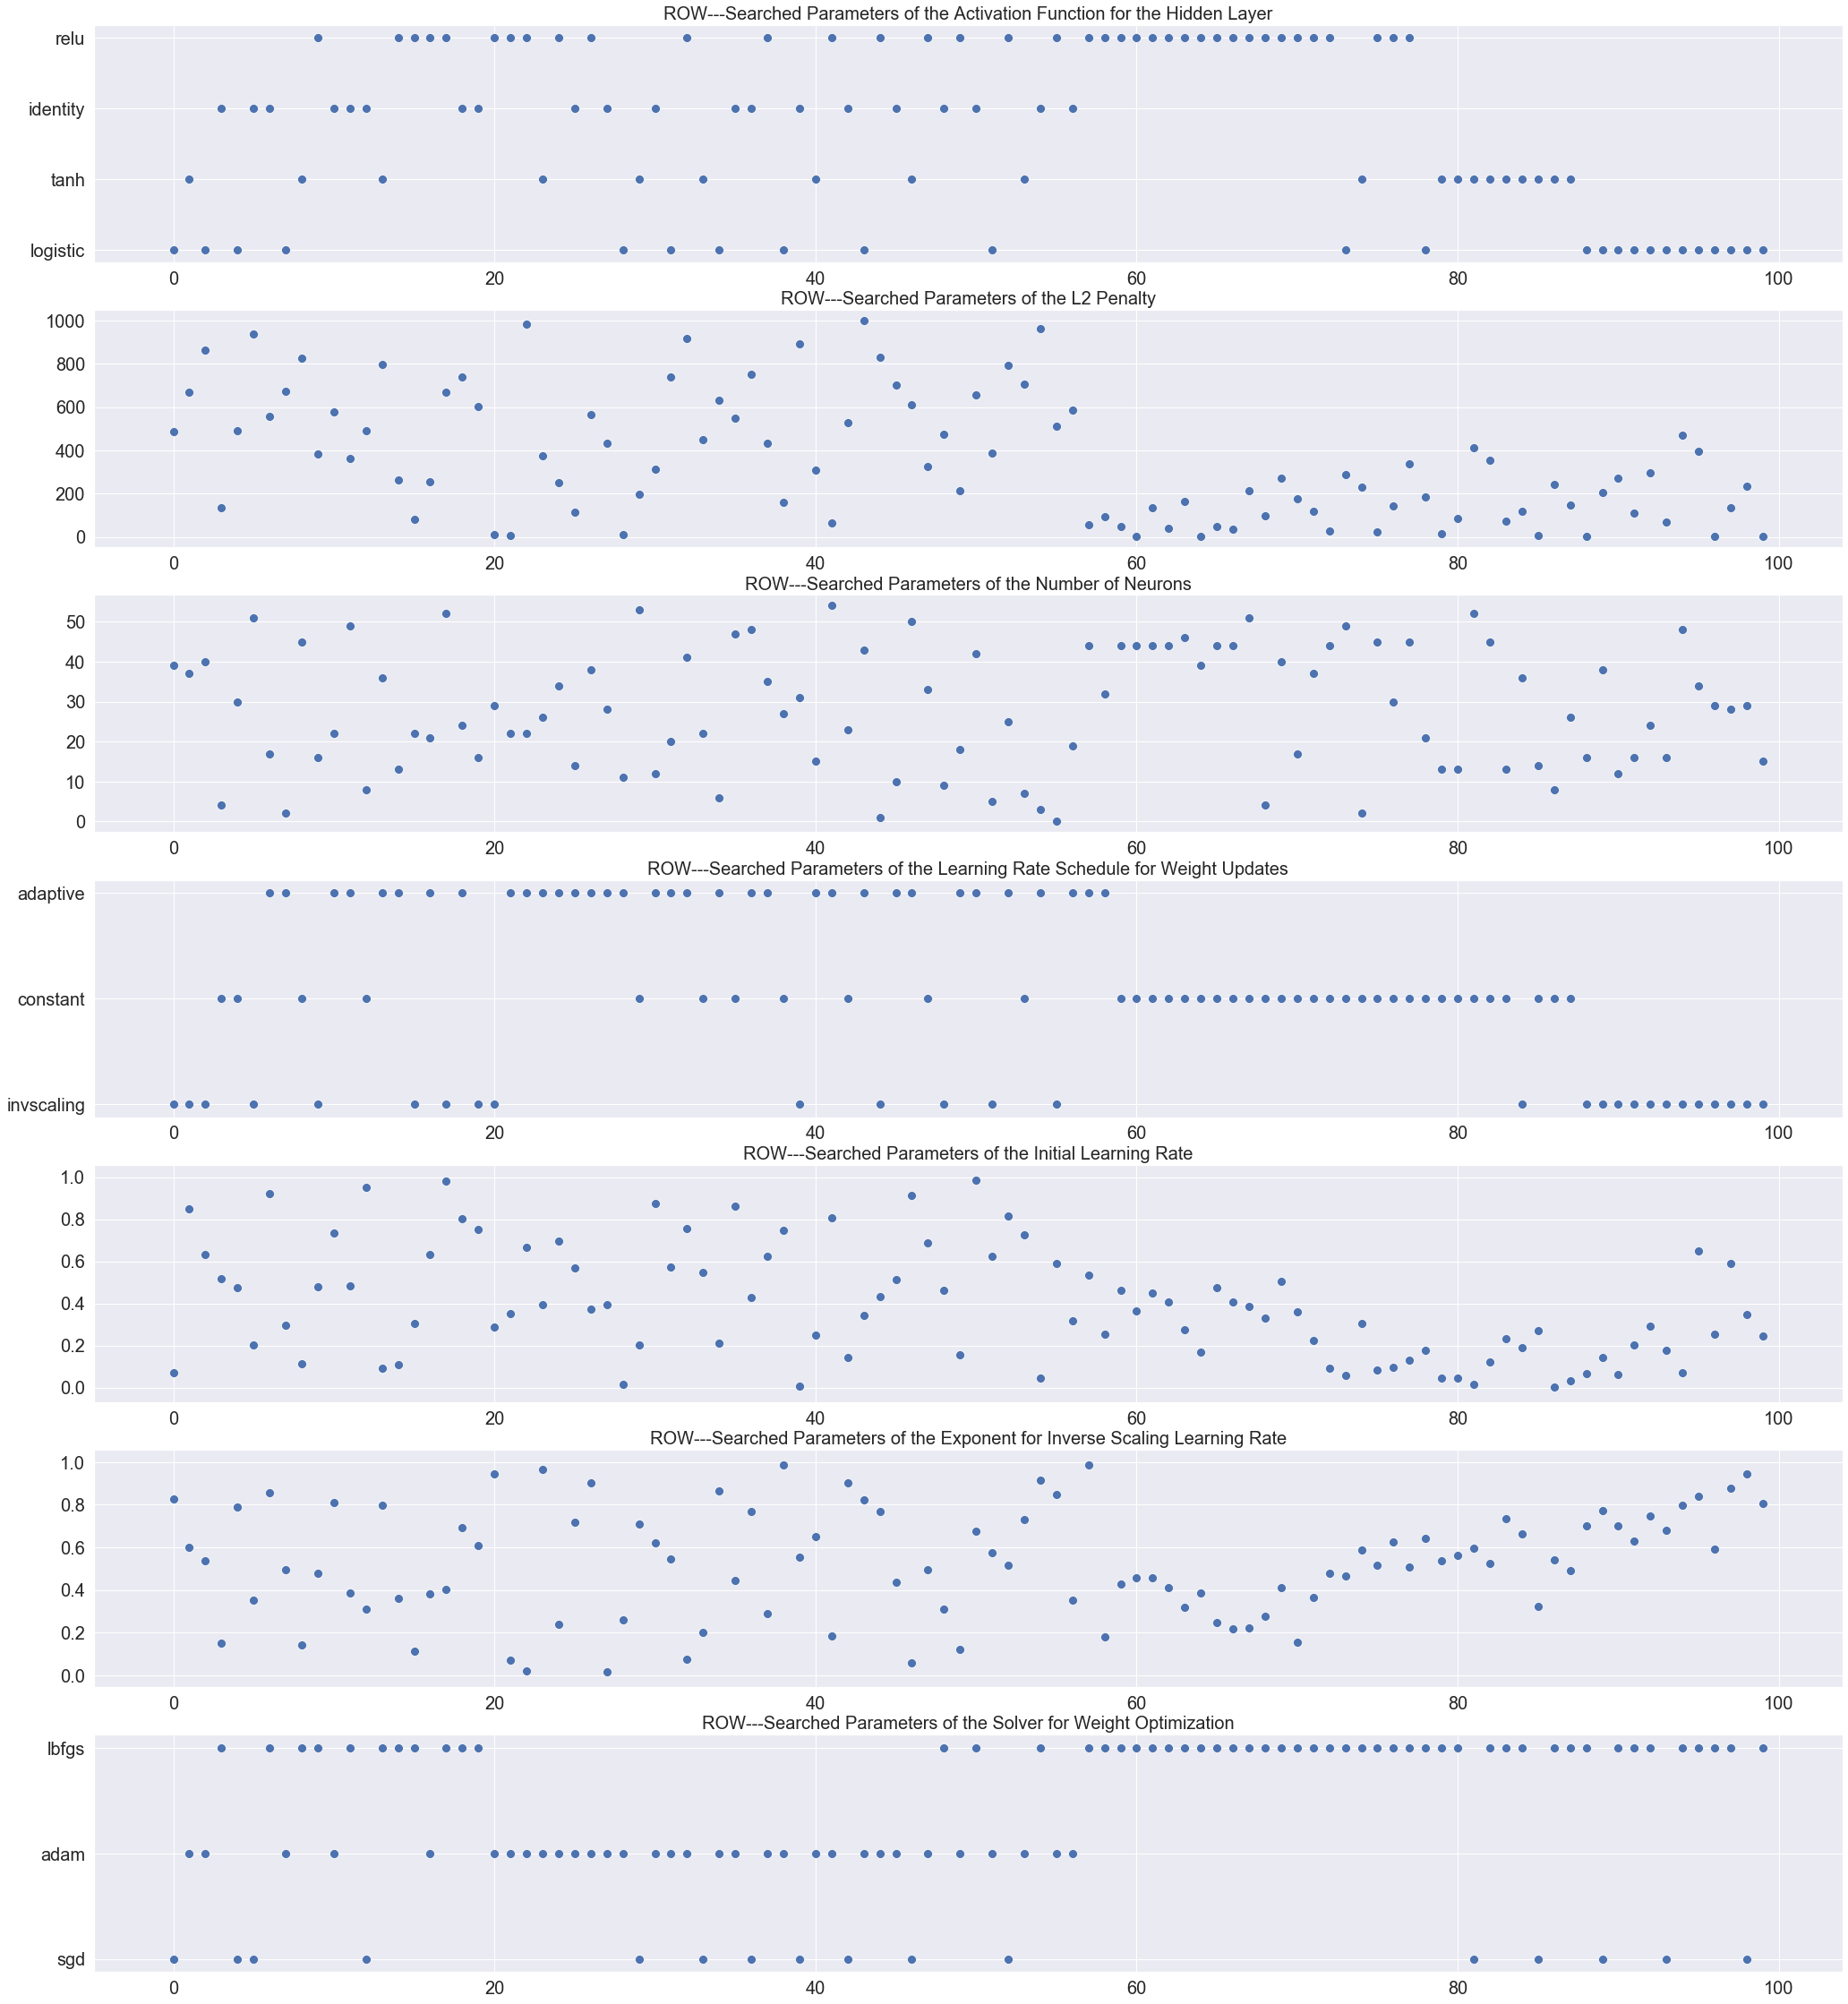

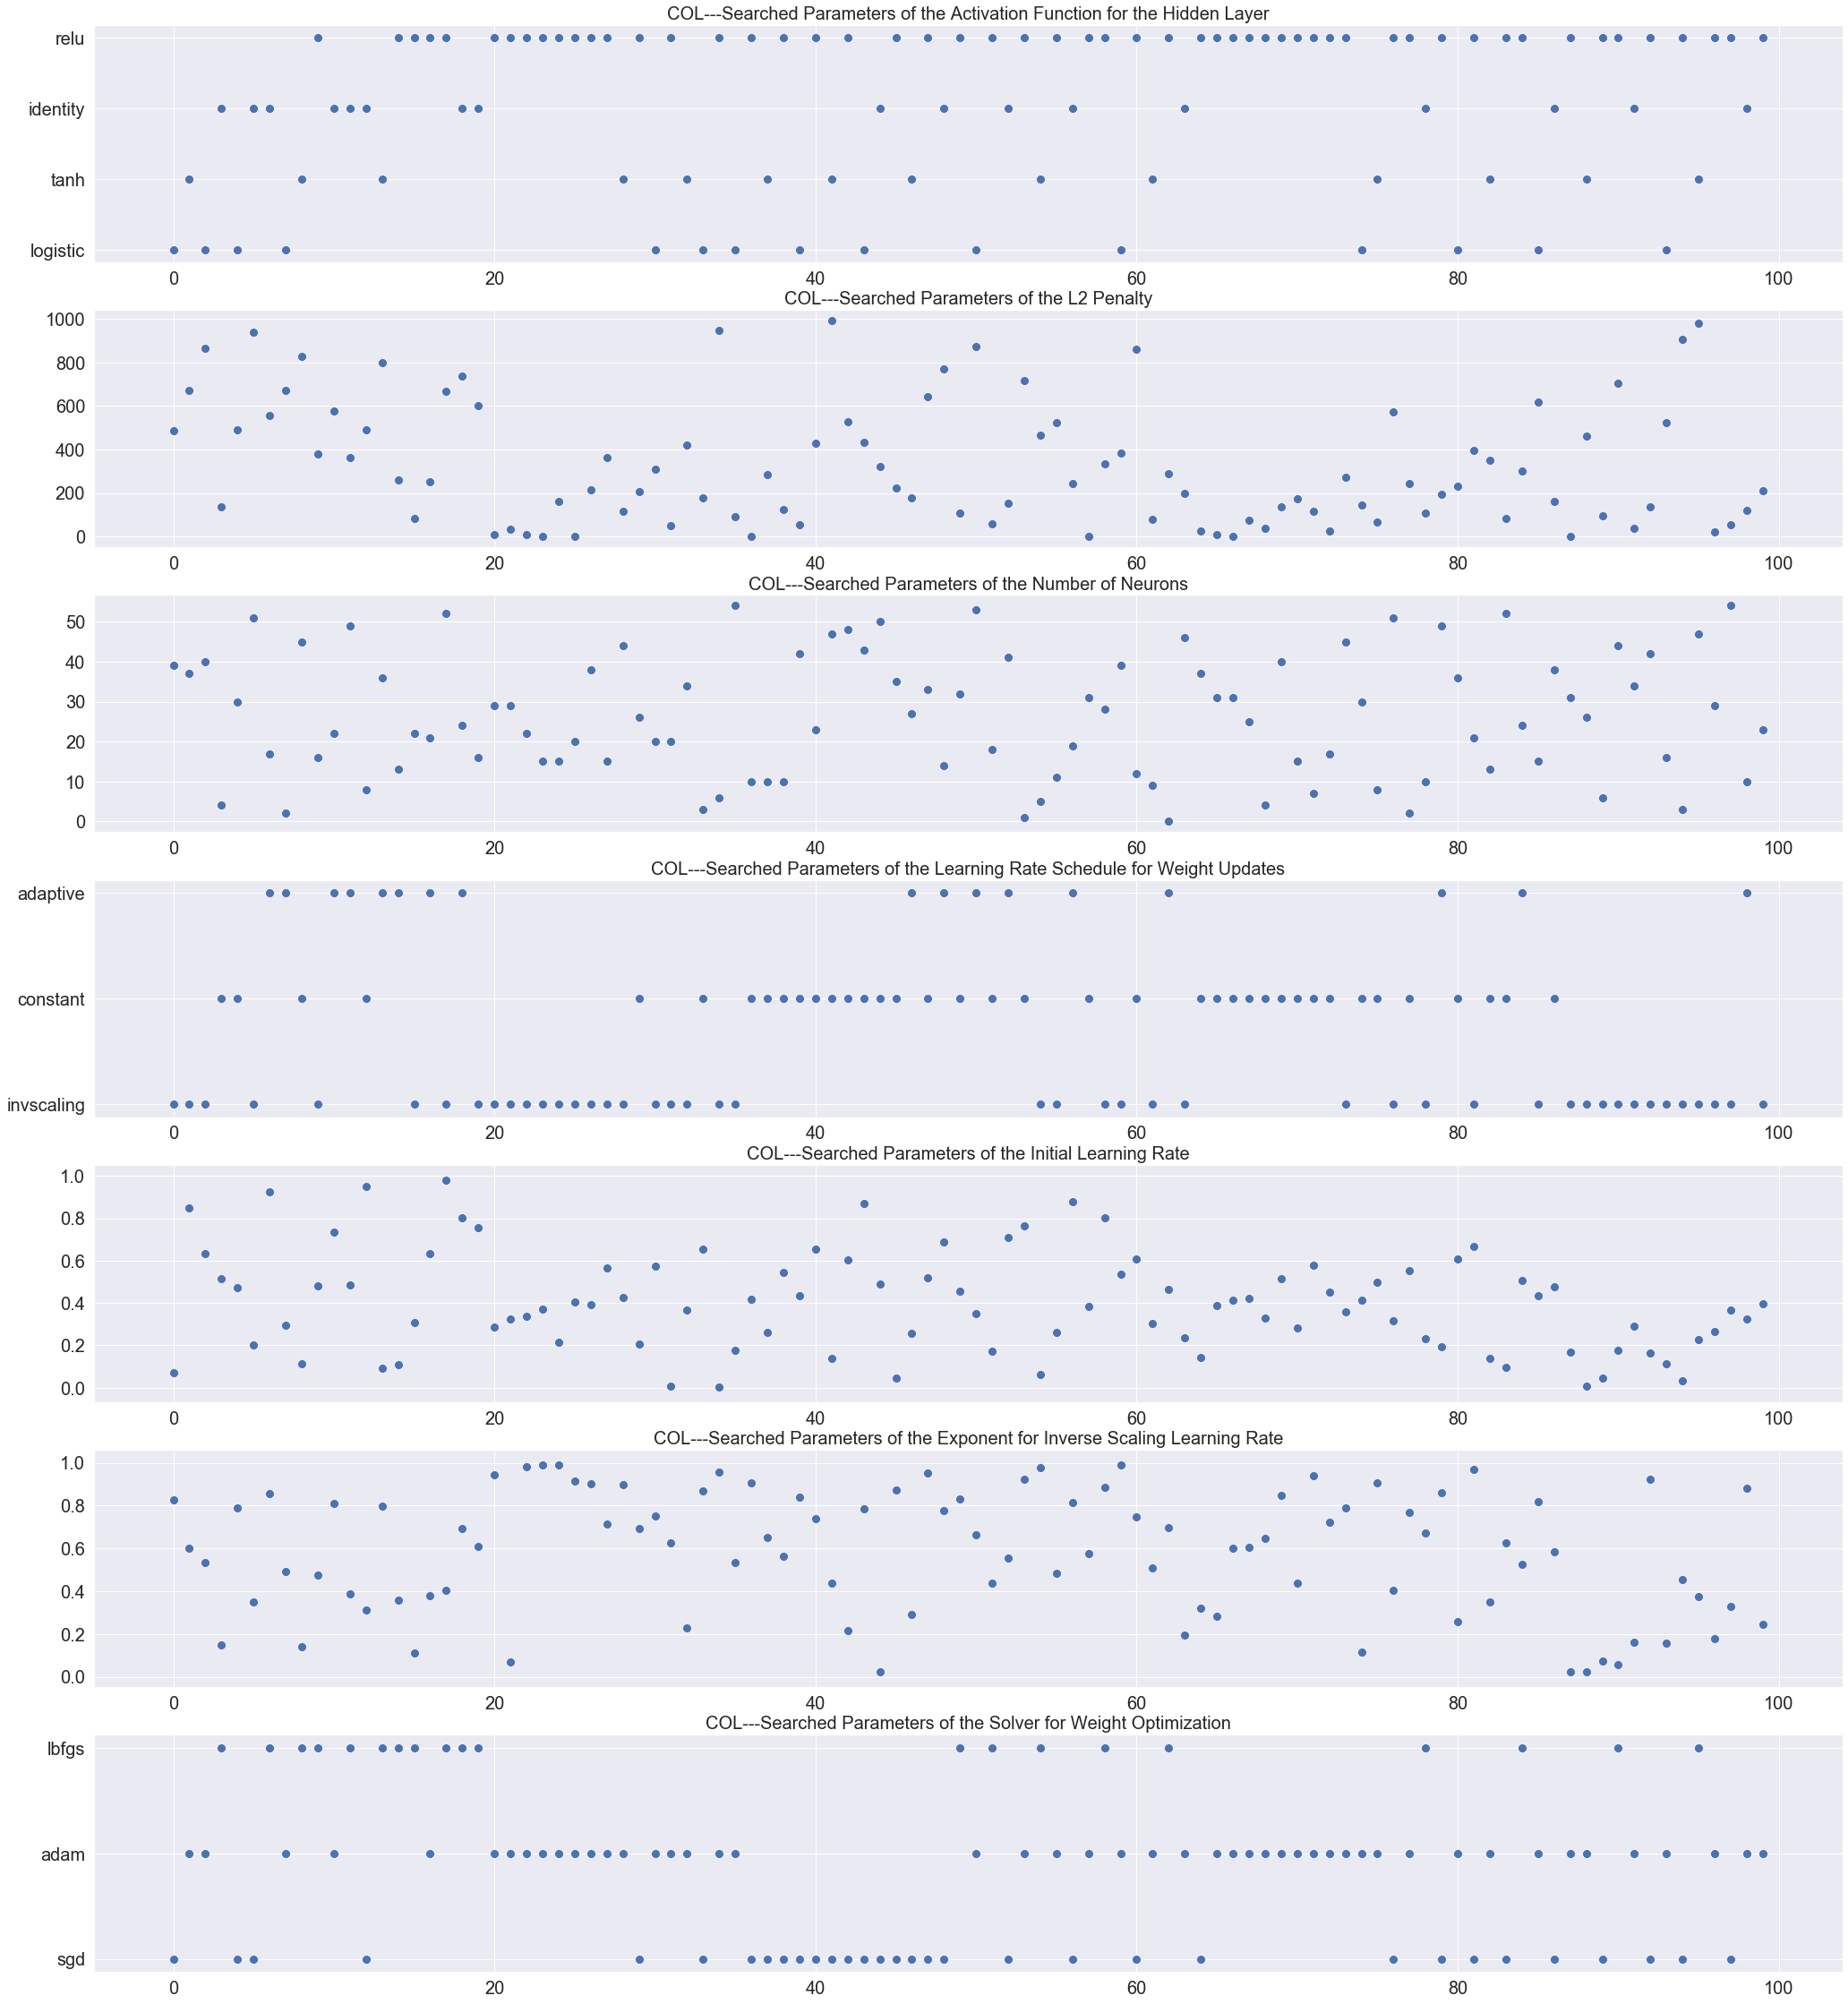

In [72]:
# Section 3.2 Building MLP
# Train/test split
y_train = [None] * len(target)
y_test = [None] * len(target)

for i in range(len(target)):
    X_train, X_test, y_train[i], y_test[i] = train_test_split(X, y[i],
                                                              test_size=1/3,
                                                              random_state=42,
                                                              stratify=y[0])
    
# Set up space dictionary with specified hyperparameters
space = {'hidden_layer_sizes': hp.choice('hidden_layer_sizes', range(1,56)),
         'activation': hp.choice('activation', ['logistic','tanh','relu', 'identity']),
         'solver': hp.choice('solver', ['lbfgs','sgd','adam']),
         'alpha': hp.uniform('alpha', 0.0001, 1000),
         'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
         'learning_rate_init': hp.uniform('learning_rate_init', 0.001, 0.99),
         'power_t': hp.uniform('power_t', 0.01, 0.99)}

wave = -1

target_clf = [None] * len(target)
target_clf_fitted = [None] * len(target)
target_y_pred_proba = [None] * len(target)
target_y_pred = [None] * len(target)

for i in range(len(target)):
    target_clf[i] = [None] * 12
    target_clf_fitted[i] = [None] * 12
    target_y_pred_proba[i] = [None] * 12
    target_y_pred[i] = [None] * 12

for (i, j) in zip(range(len(target)), ['multilabels', 'SB', 'ROW', 'COL']):
    
    wave = wave + 1
    
    # Set up objective function
    def objective(params):
        params = {'hidden_layer_sizes': params['hidden_layer_sizes'],
                  'activation': params['activation'],
                  'solver': params['solver'],
                  'alpha': params['alpha'],
                  'learning_rate': params['learning_rate'],
                  'learning_rate_init': params['learning_rate_init'],
                  'power_t': params['power_t']}
        
        hyperopt_clf = MLPClassifier(max_iter=4000,
                                     random_state=42,
                                     warm_start=True,
                                     early_stopping=True,
                                     **params)

        best_score = cross_val_score(estimator=hyperopt_clf,
                                     X=X_train,
                                     y=y_train[i],
                                     cv=3,
                                     n_jobs=4,
                                     pre_dispatch=10).mean()
    
        loss = 1 - best_score
        return {'best_score': best_score, 'loss': loss, 'status': STATUS_OK,'eval_time': time.time()}

    # Run the algorithm
    trials = Trials()
    best = fmin(fn=objective,
           space=space,
           max_evals=100,
           rstate=np.random.RandomState(42),
           algo=tpe.suggest,
           trials=trials)
    
    print('{}----------'.format(j))
    
    best_score = [None] * len(trials.trials)
    best_score[0] = trials.results[0].get('best_score')

    searched_params_df = pd.DataFrame(trials.trials[0].get('misc').get('vals').values())
    searched_params_df = searched_params_df.transpose()

    for i in list(range(1, len(trials.trials))):
        new_df = pd.DataFrame(trials.trials[i].get('misc').get('vals').values())
        searched_params_df = searched_params_df.append(new_df.transpose())
        best_score[i] = trials.results[i].get('best_score')

    searched_params_df = searched_params_df.rename(columns={0: 'activation', 1: 'alpha', 2: 'hidden_layer_sizes', 
                                                            3: 'learning_rate', 4: 'learning_rate_init', 
                                                            5: 'power_t', 6: 'solver'})
    
    blankIndex = [''] * len(searched_params_df)
    searched_params_df.index = blankIndex
    
    i = ['activation', 'learning_rate', 'solver']
    j = ['logistic', 'constant', 'lbfgs']
    k = ['tanh', 'invscaling', 'sgd']
    l = ['relu', 'adaptive', 'adam']
    m = ['identity']

    for (i, j, k, l) in zip(i, j, k, l):
         searched_params_df[i] = searched_params_df[i].replace({0: j, 1: k, 2: l, 3: m})

    searched_params_df['best_score'] = best_score

    searched_params_df_sorted = searched_params_df.sort_values(by='best_score', 
                                                               axis=0, 
                                                               ascending=False)
    
    searched_params_df_sorted = searched_params_df_sorted[searched_params_df_sorted.hidden_layer_sizes != 0]

    print(searched_params_df_sorted.head(5).transpose())
    print('__________')
    
    # Learn to predict each class against the other
        
    for i in range(5):
        target_clf[wave][i] = MLPClassifier(max_iter=4000,
                                            random_state=42,
                                            warm_start=True,
                                            early_stopping=True,
                                            activation=searched_params_df_sorted.values[i][0],
                                            alpha=searched_params_df_sorted.values[i][1],
                                            hidden_layer_sizes=int(searched_params_df_sorted.values[i][2]),
                                            learning_rate=searched_params_df_sorted.values[i][3],
                                            learning_rate_init=searched_params_df_sorted.values[i][4],
                                            power_t=searched_params_df_sorted.values[i][5],
                                            solver=searched_params_df_sorted.values[i][6])
    
    if wave == 0:
        for i in range(5):
            target_clf_fitted[wave][i] = target_clf[wave][i].fit(X_train, y_train[wave])
            target_y_pred_proba[wave][i] = target_clf[wave][i].predict_proba(X_test)
            target_y_pred[wave][i] = target_clf[wave][i].predict(X_test)
    else:
        # Create and fit the voting classifier
        target_clf[wave][5] = VotingClassifier(estimators=[('first', target_clf[wave][0]), 
                                                           ('second', target_clf[wave][1]), 
                                                           ('third', target_clf[wave][2]), 
                                                           ('forth', target_clf[wave][3]),
                                                           ('fifth', target_clf[wave][4])],
                                                voting='soft',
                                                n_jobs=4)
    
        for i in range(6):
            target_clf_fitted[wave][i] = target_clf[wave][i].fit(X_train, y_train[wave])
            target_y_pred_proba[wave][i] = target_clf[wave][i].predict_proba(X_test)
            target_y_pred[wave][i] = target_clf[wave][i].predict(X_test)

    # Create the parameter grid
    ##param_grid = {'hidden_layer_sizes': list(product(range(1,56), range(1,56)))}
    
    # Create a random search object
    ##ran_clf = RandomizedSearchCV(estimator = MLPClassifier(max_iter=4000,
                                                           ##random_state=42,
                                                           ##warm_start=True,
                                                           ##early_stopping=True,
                                                           ##activation=searched_params_df_sorted.values[0][0],
                                                           ##alpha=searched_params_df_sorted.values[0][1],
                                                           ##learning_rate=searched_params_df_sorted.values[0][3],
                                                           ##learning_rate_init=searched_params_df_sorted.values[0][4],
                                                           ##power_t=searched_params_df_sorted.values[0][5],
                                                           ##solver=searched_params_df_sorted.values[0][6]),
                                 ##param_distributions=param_grid,
                                 ##n_iter=465,
                                 ##n_jobs=4,
                                 ##pre_dispatch=100,
                                 ##cv=3,
                                 ##random_state=42)

    ##ran_clf_fitted = ran_clf.fit(X_train, y_train[wave])

    #Configuration of Layer 1 & 2
    ##mean_test_score = list(ran_clf_fitted.cv_results_.get('mean_test_score'))
    ##hidden_layers = list(ran_clf_fitted.cv_results_.get('param_hidden_layer_sizes'))

    ##best_hidden_layers_df = pd.DataFrame({'Hidden Layers': hidden_layers, 'Mean Test Score': mean_test_score})

    ##blankIndex = [''] * len(best_hidden_layers_df)
    ##best_hidden_layers_df.index = blankIndex

    # Print out the best configuration of hidden layers
    ##best_hidden_layers_df_sorted = best_hidden_layers_df.sort_values(by='Mean Test Score', 
                                                                     ##axis=0, 
                                                                     ##ascending=False)

    ##print(best_hidden_layers_df_sorted.head(5).transpose())
    ##print()

    ##for i in range(6, 11):
        ##target_clf[wave][i] = MLPClassifier(max_iter=4000,
                                            ##random_state=42,
                                            ##warm_start=True,
                                            ##early_stopping=True,
                                            ##activation=searched_params_df_sorted.values[0][0],
                                            ##alpha=searched_params_df_sorted.values[0][1],
                                            ##hidden_layer_sizes=best_hidden_layers_df_sorted['Hidden Layers'].values[i-6],
                                            ##learning_rate=searched_params_df_sorted.values[0][3],
                                            ##learning_rate_init=searched_params_df_sorted.values[0][4],
                                            ##power_t=searched_params_df_sorted.values[0][5],
                                            ##solver=searched_params_df_sorted.values[0][6])
    
    ##if wave == 0:
        ##for i in range(6, 11):
            ##target_clf_fitted[wave][i] = target_clf[wave][i].fit(X_train, y_train[wave])
            ##target_y_pred_proba[wave][i] = target_clf[wave][i].predict_proba(X_test)
            ##target_y_pred[wave][i] = target_clf[wave][i].predict(X_test)
    ##else:
        # Create and fit the voting classifier
        ##target_clf[wave][11] = VotingClassifier(estimators=[('first', target_clf[wave][6]), 
                                                            ##('second', target_clf[wave][7]), 
                                                            ##('third', target_clf[wave][8]), 
                                                            ##('forth', target_clf[wave][9]),
                                                            ##('fifth', target_clf[wave][10])],
                                                ##voting='soft',
                                                ##n_jobs=4)
    
        ##for i in range(6, 12):
            ##target_clf_fitted[wave][i] = target_clf[wave][i].fit(X_train, y_train[wave])
            ##target_y_pred_proba[wave][i] = target_clf[wave][i].predict_proba(X_test)
            ##target_y_pred[wave][i] = target_clf[wave][i].predict(X_test)
    
    #sns.set(rc={'figure.figsize': (20,20), 'legend.fontsize': 25, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 
            #'lines.markersize': 10, 'axes.labelsize': 20, 'axes.titlesize': 20})

    #first_hidden_layer = [None] * len(hidden_layers)
    #second_hidden_layer = [None] * len(hidden_layers)

    #for i in range(len(hidden_layers)):
        #first_hidden_layer[i] = hidden_layers[i][0]
        #second_hidden_layer[i] = hidden_layers[i][1]

    #ax = sns.scatterplot(x=first_hidden_layer,
                         #y=second_hidden_layer)
    #ax.set_title('Scatterplot of the Combination of the Number of Neurons in the First & Second Hidden Layers')
 
    # Color the points according to types of failure
    sns.set(rc={'figure.figsize': (35,40), 'legend.fontsize': 25, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                'lines.markersize': 10, 'axes.labelsize': 0, 'axes.titlesize': 20})

    fig, ax = plt.subplots(7,1)

    j = ['Activation Function for the Hidden Layer', 'L2 Penalty', 'Number of Neurons', 
         'Learning Rate Schedule for Weight Updates', 'Initial Learning Rate', 'Exponent for Inverse Scaling Learning Rate',
         'Solver for Weight Optimization']
    k = ['activation', 'alpha', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'power_t', 'solver']
    
    for (i, j, k) in zip(range(7), j, k):
    
        ax[i].set_title('{}---Searched Parameters of the {}'.format(target[wave], j))
        sns.scatterplot(x=list(range(0, len(trials.trials))), 
                        y=searched_params_df[k].values, 
                        ax=ax[i])
        


In [73]:
# Print classification report
wave = -1

for (i, j) in zip(range(len(target)), ['multilabels', 'SB', 'ROW', 'COL']):
    wave = wave + 1
    
    print(j)
    
    if wave == 0:
        i = [0, 1, 2, 3, 4]
        j = ['1stBest_1Layer', '2ndBest_1Layer', '3rdBest_1Layer', '4thBest_1Layer', '5thBest_1Layer']

        for (i, j) in zip(i, j):
            print('{}----------'.format(j))
            print()
            print(multilabel_confusion_matrix(y_true=y_test[wave], 
                                              y_pred=target_y_pred[wave][i]))
            print(classification_report(y_true=y_test[wave], 
                                        y_pred=target_y_pred[wave][i],
                                        target_names=['SB', 'ROW', 'COL'],
                                        digits=2))
    else:
        i = [0, 1, 2, 3, 4, 5]
        j = ['1stBest_1Layer', '2ndBest_1Layer', '3rdBest_1Layer', '4thBest_1Layer', '5thBest_1Layer', 'CombineBest_1Layer']

        for (i, j) in zip(i, j):
            print('{}----------'.format(j))
            print()
            print(confusion_matrix(y_true=y_test[wave], 
                                   y_pred=target_y_pred[wave][i]))
            print(classification_report(y_true=y_test[wave], 
                                        y_pred=target_y_pred[wave][i],
                                        target_names=['NonFault', 'Fault'],
                                        digits=2))
            

multilabels
1stBest_1Layer----------

[[[141 255]
  [  0 635]]

 [[775  16]
  [102 138]]

 [[595  42]
  [ 23 371]]]
              precision    recall  f1-score   support

          SB       0.71      1.00      0.83       635
         ROW       0.90      0.57      0.70       240
         COL       0.90      0.94      0.92       394

   micro avg       0.79      0.90      0.84      1269
   macro avg       0.84      0.84      0.82      1269
weighted avg       0.81      0.90      0.83      1269
 samples avg       0.79      0.84      0.80      1269

2ndBest_1Layer----------

[[[139 257]
  [  0 635]]

 [[775  16]
  [102 138]]

 [[596  41]
  [ 26 368]]]
              precision    recall  f1-score   support

          SB       0.71      1.00      0.83       635
         ROW       0.90      0.57      0.70       240
         COL       0.90      0.93      0.92       394

   micro avg       0.78      0.90      0.84      1269
   macro avg       0.84      0.84      0.82      1269
weighted avg       


4thBest_1Layer----------

[[627  10]
 [  1 393]]
              precision    recall  f1-score   support

    NonFault       1.00      0.98      0.99       637
       Fault       0.98      1.00      0.99       394

    accuracy                           0.99      1031
   macro avg       0.99      0.99      0.99      1031
weighted avg       0.99      0.99      0.99      1031

5thBest_1Layer----------

[[618  19]
 [  2 392]]
              precision    recall  f1-score   support

    NonFault       1.00      0.97      0.98       637
       Fault       0.95      0.99      0.97       394

    accuracy                           0.98      1031
   macro avg       0.98      0.98      0.98      1031
weighted avg       0.98      0.98      0.98      1031

CombineBest_1Layer----------

[[628   9]
 [  3 391]]
              precision    recall  f1-score   support

    NonFault       1.00      0.99      0.99       637
       Fault       0.98      0.99      0.98       394

    accuracy                  

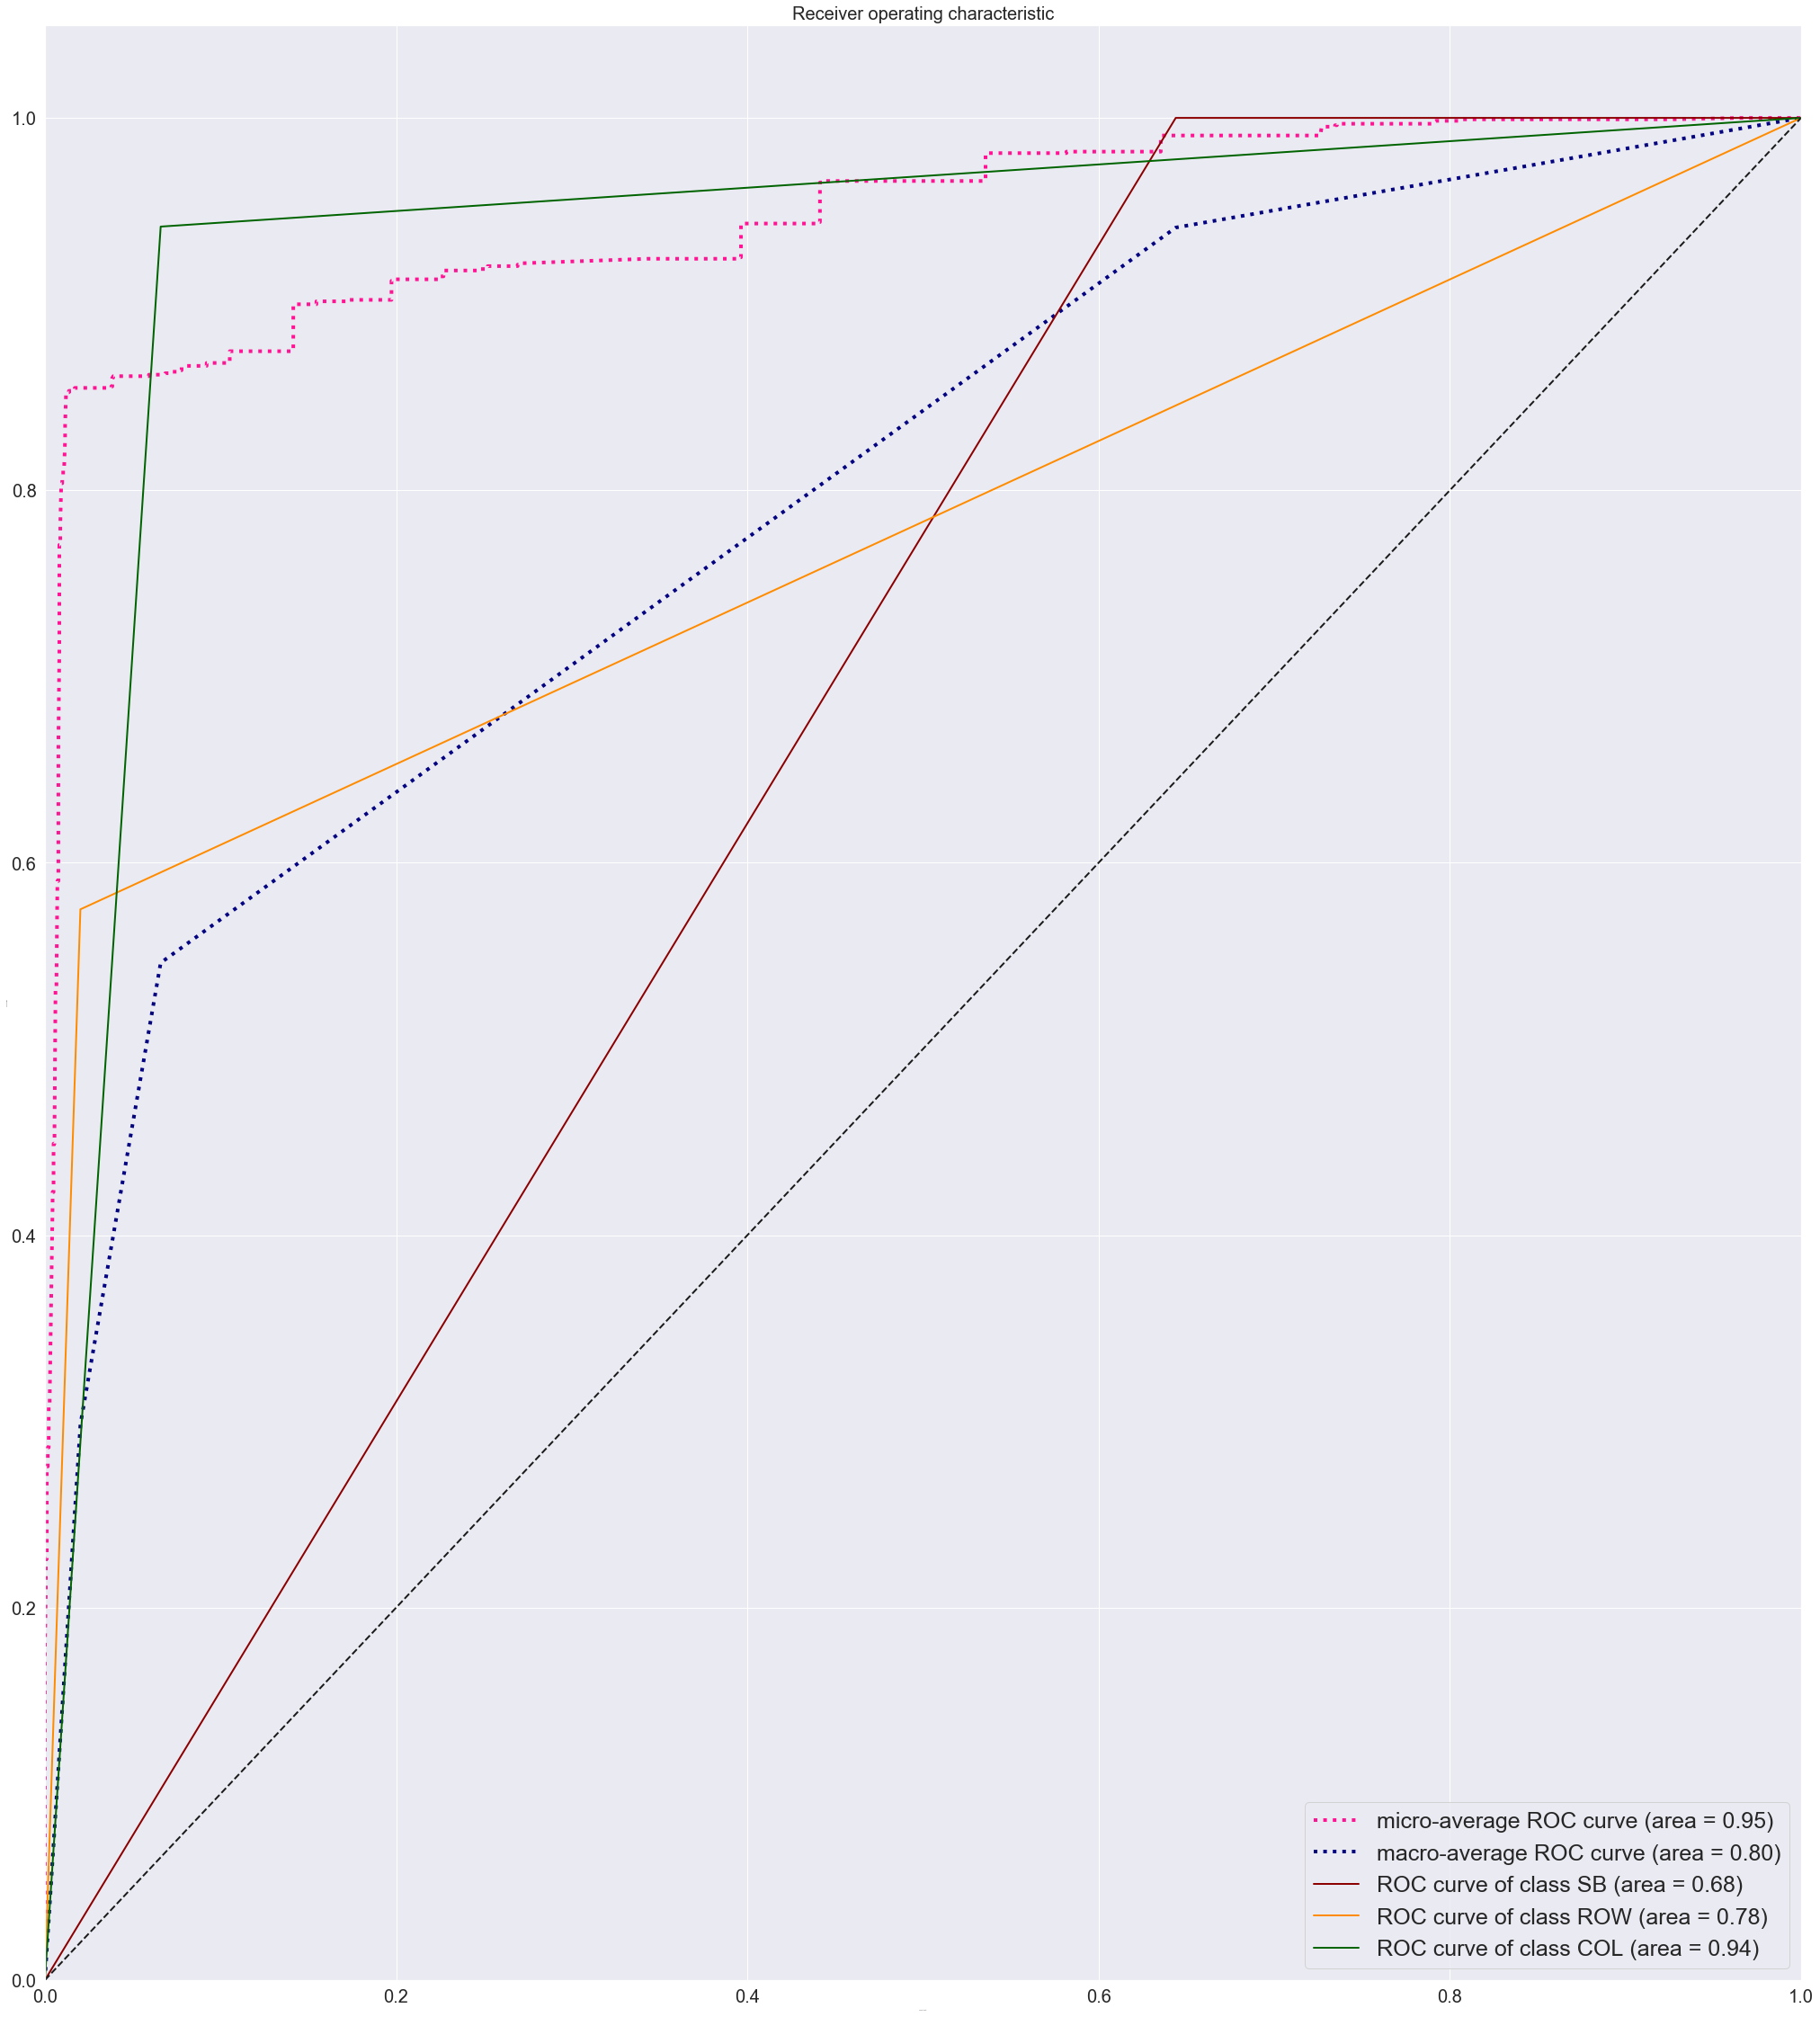

In [74]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[0][:, i], target_y_pred[0][0][:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test[0].ravel(), target_y_pred_proba[0][0].ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['darkred','darkorange','darkgreen'])
labels = cycle(['SB','ROW','COL'])
for i,color,label in zip(range(n_classes),colors,labels):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [75]:
# Computing feature importance
print('Best MLP estimator: {}'.format(target_clf[0][0]))
print()
print('Best results')
print(multilabel_confusion_matrix(y_true=y_test[0], 
                                  y_pred=target_y_pred[0][0]))
print(classification_report(y_true=y_test[0], 
                            y_pred=target_y_pred[0][0],
                            target_names=['SB', 'ROW', 'COL'],
                            digits=2))

perm = PermutationImportance(estimator=target_clf[0][0],
                             n_iter=100,
                             random_state=42).fit(X_test, y_test[0])

# Create a dataframe of the variables and feature importances
feature_importances_df = pd.DataFrame({'Variable': X.columns, 'Feature_Importances': perm.feature_importances_})

# Print out the top 3 positive variables
feature_importances_df_sorted = feature_importances_df.sort_values(by='Feature_Importances', 
                                                                   axis=0, 
                                                                   ascending=False)
print()
print(feature_importances_df_sorted)

mlp=target_clf[0][0]

Best MLP estimator: MLPClassifier(activation='relu', alpha=5.091254011434307, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=9, learning_rate='constant',
              learning_rate_init=0.5171840179154447, max_iter=4000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.4768853983596606, random_state=42, shuffle=True,
              solver='lbfgs', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=True)

Best results
[[[141 255]
  [  0 635]]

 [[775  16]
  [102 138]]

 [[595  42]
  [ 23 371]]]
              precision    recall  f1-score   support

          SB       0.71      1.00      0.83       635
         ROW       0.90      0.57      0.70       240
         COL       0.90      0.94      0.92       394

   micro avg       0.79      0.90      0.84      1269
   macro avg       0.84      0.84      0.82      1269
weighted avg       

In [76]:
#Section 4: Re-train chance of individual based on competition result.

In [77]:
from sklearn.ensemble import VotingClassifier

X_train,X_test,y_train,y_test=X_train_b,X_test_b,y_train_b,y_test_b

mlp1=eval("%s" % mlp)

#print(svm.predict(X_test))
#Extracting ROW/COL/SB y and predict result from multilabel array as sklearn metrics may not support multilabel for bagging classifier.
y_train_row=[]
y_test_row=[]
dt_pred_row=[]
svm_pred_row=[]
for elem in y_train:
    y_train_row.append(elem[1])
for elem in y_test:    
    y_test_row.append(elem[1])
for elem in dt.predict(X_test):    
    dt_pred_row.append(elem[1])
for elem in svm.predict(X_test):    
    svm_pred_row.append(elem[1])
#for elem in mlp1.predict(X_test):    
#    mlp_pred_row.append(elem[0])
    
y_train_col=[]
y_test_col=[]
dt_pred_col=[]
svm_pred_col=[]
for elem in y_train:
    y_train_col.append(elem[1])
for elem in y_test:    
    y_test_col.append(elem[1])
for elem in dt.predict(X_test):    
    dt_pred_col.append(elem[1])
for elem in svm.predict(X_test):    
    svm_pred_col.append(elem[1])
#for elem in mlp1.predict(X_test):    
#    mlp_pred_col.append(elem[1])
    
y_train_sb=[]
y_test_sb=[]
dt_pred_sb=[]
svm_pred_sb=[]
for elem in y_train:
    y_train_sb.append(elem[0])
for elem in y_test:    
    y_test_sb.append(elem[0])
for elem in dt.predict(X_test):    
    dt_pred_sb.append(elem[0])
for elem in svm.predict(X_test):    
    svm_pred_sb.append(elem[0])
#for elem in mlp1.predict(X_test):    
#    mlp_pred_sb.append(elem[2])

dt_row=eval("%s" % dt) 
dt_row.fit(X_train,y_train_row)
dt_col=eval("%s" % dt) 
dt_col.fit(X_train,y_train_col)
dt_sb=eval("%s" % dt) 
dt_sb.fit(X_train,y_train_sb)


mlp_row=eval("%s" % mlp1)
mlp_row.fit(X_train,y_train_row)
mlp_col=eval("%s" % mlp1)
mlp_col.fit(X_train,y_train_col)
mlp_sb=eval("%s" % mlp1)
mlp_sb.fit(X_train,y_train_sb)

mlp_pred_sb=mlp_sb.predict(X_test)
mlp_pred_row=mlp_row.predict(X_test)
mlp_pred_col=mlp_col.predict(X_test)

svm_row=eval("%s" % svm_single) 
svm_row.fit(X_train,y_train_row)
svm_col=eval("%s" % svm_single) 
svm_col.fit(X_train,y_train_col)
svm_sb=eval("%s" % svm_single) 
svm_sb.fit(X_train,y_train_sb)


#print(y_train_row)
false_pass_count=[
    confusion_matrix(y_test_row,dt_pred_row )[1][0] + confusion_matrix(y_test_col,dt_pred_col )[1][0] + confusion_matrix(y_test_sb,dt_pred_sb )[1][0],
    confusion_matrix(y_test_row,svm_pred_row )[1][0] + confusion_matrix(y_test_col,svm_pred_col )[1][0] + confusion_matrix(y_test_sb,svm_pred_sb )[1][0],
    confusion_matrix(y_test_row,mlp_pred_row ) [1][0] + confusion_matrix(y_test_col,mlp_pred_col )[1][0] + confusion_matrix(y_test_sb,mlp_pred_sb )[1][0]
]

#print(false_pass_count[0])
    

#For each DT,
for i in range(3):
    if max(false_pass_count)==false_pass_count[i]:
        if i==1:
            
            best_num_tree=48
            max_score=0
            for num_trees in [48,96,192,384,768,1024]:    
                dt=eval("RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',\
                max_depth=%s, max_features='auto', max_leaf_nodes=None,\
                min_impurity_decrease=%s, min_impurity_split=None,\
                min_samples_leaf=1, min_samples_split=2,\
                min_weight_fraction_leaf=%s, n_estimators=%s, n_jobs=None,\
                oob_score=False, random_state=0, verbose=0, warm_start=False)" % (max_depth,best_impurity_decrease,best_weight_fraction_leaf,num_trees) )

                dt.fit(X_train, y_train)   
                if dt.score(X_test, y_test)>max_score:
                    max_score=dt.score(X_test, y_test)
                    best_num_tree=num_trees

            
            
            dt2=eval("RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',\
            max_depth=%s, max_features='auto', max_leaf_nodes=None,\
            min_impurity_decrease=%s, min_impurity_split=None,\
            min_samples_leaf=1, min_samples_split=2,\
            min_weight_fraction_leaf=%s, n_estimators=%s, n_jobs=None,\
            oob_score=False, random_state=0, verbose=0, warm_start=False)" % (best_depth,best_impurity_decrease,best_weight_fraction_leaf,best_num_tree) )
            dt_row2=eval("%s" % dt2)
            dt_row2.fit(X_train,y_train_row)
            dt_col2=eval("%s" % dt2)
            dt_col2.fit(X_train,y_train_col)
            dt_sb2=eval("%s" % dt2)
            dt_sb2.fit(X_train,y_train_sb)
          
            
            if dt_row2.score(X_test,y_test_row)>dt_row.score(X_test,y_test_row):
                if dt_col2.score(X_test,y_test_col)>dt_col.score(X_test,y_test_col):
                    if dt_sb2.score(X_test,y_test_sb)>dt_sb.score(X_test,y_test_sb):
                        print("changed dt")
                        dt=dt2
                        dt.fit(X_train,y_train)
                        dt_row=eval("%s" % dt2)
                        dt_row.fit(X_train,y_train_row)
                        dt_col=eval("%s" % dt2)
                        dt_col.fit(X_train,y_train_col)
                        dt_sb=eval("%s" % dt2)
                        dt_sb.fit(X_train,y_train_sb)


        elif i==2:
            svm2=BaggingClassifier(base_estimator=svm, n_estimators=10)
            svm_row2=eval("%s" % svm2).fit(X_train,y_train_row)
            svm_col2=eval("%s" % svm2).fit(X_train,y_train_col)
            svm_sb2=eval("%s" % svm2).fit(X_train,y_train_sb)           
            if svm_row2.score(X_test,y_test_row)>svm_row.score(X_test,y_test_row):
                if svm_col2.score(X_test,y_test_col)>svm_col.score(X_test,y_test_col):
                    if svm_sb2.score(X_test,y_test_sb)>svm_sb.score(X_test,y_test_sb):
                        print("changed svm")
                        svm=svm2         
                        svm_row=eval("%s" % svm2).fit(X_train,y_train_row)
                        svm_col=eval("%s" % svm2).fit(X_train,y_train_col)
                        svm_sb=eval("%s" % svm2).fit(X_train,y_train_sb)           
                        
        elif i==3:
            mlp2=BaggingClassifier(base_estimator=mlp, n_estimators=10)
            mlp_row2=eval("%s" % mlp2).fit(X_train,y_train_row)
            mlp_col2=eval("%s" % mlp2).fit(X_train,y_train_col)
            mlp_sb2=eval("%s" % mlp2).fit(X_train,y_train_sb)
            if mlp_row2.score(X_test,y_test_row)>mlp_row.score(X_test,y_test):
                if mlp_col2.score(X_test,y_test_col)>mlp_col.score(X_test,y_test):
                    if mlp_sb2.score(X_test,y_test_sb)>mlp_sb.score(X_test,y_test):
                        print("changed mlp")
                        mlp=mlp2
                        #mlp.fit(X_train,y_train)            
                        mlp_row=eval("%s" % mlp2).fit(X_train,y_train_row)
                        mlp_col=eval("%s" % mlp2).fit(X_train,y_train_col)
                        mlp_sb=eval("%s" % mlp2).fit(X_train,y_train_sb)
        break


mlp_pred_sb=mlp_sb.predict(X_test)
mlp_pred_row=mlp_row.predict(X_test)
mlp_pred_col=mlp_col.predict(X_test)


svm_pred_sb=svm_sb.predict(X_test)
svm_pred_row=svm_row.predict(X_test)
svm_pred_col=svm_col.predict(X_test)


dt_pred_sb=dt_sb.predict(X_test)
dt_pred_row=dt_row.predict(X_test)
dt_pred_col=dt_col.predict(X_test)


from sklearn.metrics import accuracy_score


print(dt)
print("Random forest SB score: %s" % dt_sb.score(X_test, y_test_sb))
print("Random forest COL score: %s" % dt_col.score(X_test, y_test_col))
print("Random forest ROW score: %s" % dt_row.score(X_test, y_test_row))
dtscore=dt_sb.score(X_test, y_test_sb)*dt_col.score(X_test, y_test_col)*dt_row.score(X_test, y_test_row)
print("Overall Random Forest Score%s: " % dtscore)
print(svm)
print("SVM SB score: %s" % svm_sb.score(X_test, y_test_sb))
print("SVM COL score: %s" % svm_col.score(X_test, y_test_col))
print("SVM ROW score: %s" % svm_row.score(X_test, y_test_row))
svmscore=svm_sb.score(X_test, y_test_sb)*svm_col.score(X_test, y_test_col)*svm_row.score(X_test, y_test_row)
print("Overall svm Score%s: " % svmscore)
print(mlp)
print("mlp SB score: %s" % mlp_sb.score(X_test, y_test_sb))
print("mlp COL score: %s" % mlp_col.score(X_test, y_test_col))
print("mlp ROW score: %s" % mlp_row.score(X_test, y_test_row))
mlpscore=mlp_sb.score(X_test, y_test_sb)*mlp_col.score(X_test, y_test_col)*mlp_row.score(X_test, y_test_row)
print("Overall mlp Score%s: " % mlpscore)




RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=36, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0008, n_estimators=128,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Random forest SB score: 0.9903006789524733
Random forest COL score: 0.9844810863239574
Random forest ROW score: 0.9844810863239574
Overall Random Forest Score0.9598023981818824: 
OneVsRestClassifier(estimator=SVC(C=3, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='auto_deprecated',
                                  kernel='linear', max_iter=-1,
                                  probabili

In [78]:
#Section 5: Voting ensemble as final output of the system

VoteSysRow=VotingClassifier(estimators=[('first', dt_row), 
                            ('second',svm_row ) ,                            
                            ('third',mlp_row ) 
                                       ],
                                                voting='soft')

#print(y_test_row)
VoteSysRow=VoteSysRow.fit(X_train, y_train_row)
print(VoteSysRow)

FinalPred = VoteSysRow.predict(X_test)
  
          


FinalPredProba = VoteSysRow.predict_proba(X_test)
print(confusion_matrix(y_test_row,FinalPred))  
print(classification_report(y_test_row,FinalPred)) 

print(VoteSysRow.score(X_test,y_test_row))  

                           
#X_train,X_test,y_train_col,y_test_col = train_test_split(X,test_data.COL,test_size=1/3,random_state=2, stratify=test_data.COL)


dt_col=dt.fit(X_train,y_train_col)
svm_col=svm_single.fit(X_train,y_train_col)
mlp_col=mlp1.fit(X_train,y_train_col)
#print (svm_col.predict(X_test))
VoteSyscol=VotingClassifier(estimators=[('first', dt_col), 
                            ('second',svm_col ) ,                            
                            ('third',mlp_col ) 
                                       ],
                                                voting='soft')

#print(y_test_col)
VoteSyscol=VoteSyscol.fit(X_train, y_train_col)
print(VoteSyscol)

FinalPred = VoteSyscol.predict(X_test)
  
          


FinalPredProba = VoteSyscol.predict_proba(X_test)
print(confusion_matrix(y_test_col,FinalPred))  
print(classification_report(y_test_col,FinalPred)) 

print(VoteSyscol.score(X_test,y_test_col))  

#X_train,X_test,y_train_sb,y_test_sb = train_test_split(X,test_data.SB,test_size=1/3,random_state=2, stratify=test_data.SB)


dt_sb=dt.fit(X_train,y_train_sb)
svm_sb=svm_single.fit(X_train,y_train_sb)
mlp_sb=mlp1.fit(X_train,y_train_sb)
#print (svm_sb.predict(X_test))
VoteSyssb=VotingClassifier(estimators=[('first', dt_sb), 
                            ('second',svm_sb ) ,                            
                            ('third',mlp_sb ) ,
                                       ],
                                                voting='soft')

#print(y_test_sb)
VoteSyssb=VoteSyssb.fit(X_train, y_train_sb)
print(VoteSyssb)

FinalPred = VoteSyssb.predict(X_test)
  
          


FinalPredProba = VoteSyssb.predict_proba(X_test)
print(confusion_matrix(y_test_sb,FinalPred))  
print(classification_report(y_test_sb,FinalPred)) 

print(VoteSyssb.score(X_test,y_test_sb))  

vscore=VoteSyssb.score(X_test, y_test_sb)*VoteSyscol.score(X_test, y_test_col)*VoteSysRow.score(X_test, y_test_row)
print("Overall Voting System Score%s: " % vscore)
     


VotingClassifier(estimators=[('first',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=36,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0001,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0008,
                                                     n_estimators=128,
                                                     n_jobs=None,
